# Checking correlation residuals and true actuals - IMF Data analysis

Version: 1.9<br>
Date: 4 Apr 2019

Author: Ithai van Emmerik <br>
email: ithai.vanemmerik@ccc.ox.ac.uk

## Docstring

This file is meant to give an overview of some preliminary data analysis, in which the residuals are regressed on the independent variables to see if there may be any systematic bias in the forecasts.

## Introduction

This file will analyse the data from 23 publications of the World Economic Outlook (WEO). Having separated the true actual values of economic variables and the WEO forecasts of the economic variables, I have been able to calculate the residual: the difference between these true actuals and the WEO forecasts. Mathematically, this can be represented as such: 

\begin{align}
y & = \beta_0 + \beta_1 x_1 + \beta_2 x_2 ... \beta_p x_p + \epsilon \\
\hat{y} & = \beta_0 + \beta_1 x_1 + \beta_2 x_2 ... \beta_p x_p \\
y - \hat{y} & = \epsilon
\end{align}

where $y$ is the actual value, $\hat{y}$ is the IMF forecast, and $\epsilon$ is the residual.

According to the zero conditional mean assumption, the residual, $\epsilon$ ought to have an expected value of zero given any value of the explanatory value, i.e. 

\begin{equation}
\mathbb{E}(u|x) = 0
\end{equation}  

In this file, I will analyse whether this assumption holds. If not, because there is a statistically significant relationship between the residual and the independent variables, it would provide an indication that there may be a systematic bias in the forecasts.

To keep this exercise simple, I have regressed the residual only on the values of that same variable for the five preceding years. By looking at the p-values and the R-squared, I find that all the six variables analysed in this file (inflation, current account, GDP percentage change, net government debt as percentage of GDP, output gap and the government structural balance as percentage of potential GDP) suffer from a potential bias, with roughly half of all p-values being significant, and average values for R-squared that range from 0.09 to 0.36. Particularly the estimations for the current account variables seem to be suffer from a violation of the zero conditional mean assumption. Consequently, there appears to be scope for improvement in the modelling of these forecasts.

---

In [25]:
from IPython.display import HTML

HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });

</script>
<br>
<center><b>The raw code for this Jupyter notebook is by default hidden for easier reading.
To toggle on/off the raw code, click here:</b></center>
<br>
<center><form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form></center>''')

In [5]:
# Initialisation
import pandas as pd
import numpy as np
import statsmodels.api as sm
import re
from collections import OrderedDict
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

In [6]:
# Specify the folder and the input for the residuals and the actuals
# When renewing the file paths, don't forget to put the file paths between quotation marks. 
# If you get an error, make sure to replace the backward slashes in your filepaths with forward slashes.
folder = "C:/Users/Student/Desktop/EE/Processed Data/"
residuals = "WEO Residuals v3.csv"

In [7]:
def Add_Var_To_Year(list_to_search, var_name): 
    """
    Find all years in values of a list, output same list with the variable name added before the year
    This function is called in the function Var_To_TS, defined below
    Input: 
        list_to_search: list of column headers
        var_name: the variable name to be added before the year headers in the list specified above
    Output:
        list_of_years: list of column headers with the variable name added before the years
    """
    list_of_years = []
    for i in list_to_search:
        # Without the list element being a string, the regex operation does not work
        i = str(i)
        # Search each string in the list, and take out all the years
        match = re.search(r'.*([1-2][0-9]{3})', i)
        if match is not None:
            # Then it found a match! Append this to the empty list defined above
            new_var_name = var_name + " " + i
            list_of_years.append(new_var_name)
        else:
            list_of_years.append(i)

    return list_of_years

In [8]:
def Var_To_TS(df, var, col_str): 
    """
    Turn the df into a time series df by taking a variable of interest and turning it from one column into columns for every year
    This function calls the Add_Var_To_Year function defined above
    Input: 
        df: dataframe of interest
        var: the variable of interest, insert as string
        col_str: string to add to new column names, this could be 'act' for actuals or 'res' for residuals
    Output:
        df_new: the new transformed dataframe
    """
    # Take only the beginning of the input df and the variable of interest
    df_new = df.iloc[:,0:5]
    df_new[var]= df.loc[:,var]
    # Restructure the data
    df_new= df_new.pivot_table(values=var, index=["WEO Country Code", "ISO", "Country", "Forecast WEO file date"], columns='Year')
    # Eliminate the pivot table hierarchy
    df_new = pd.DataFrame(df_new.to_records())

    # Rename the column headers by adding BCA to the year headers
    cols = df_new.columns.tolist()
    cols_new = Add_Var_To_Year(cols, str(var) + " " + col_str)
    df_new.columns = cols_new
    
    return df_new

In [9]:
def Regression_Result_to_Row(dep_var, indep_vars, df, pub): # OLD NAME: Results_Table_Builder()
    """
    Take the results from the regression and add it as a row to a dataframe
    This function is called in the function Results_Table_Builder() defined below
    Input: 
        dep_var: a string containing the name of the column that serves as the dependent variable
        indep_vars: a list containing the names of the columns that serve as independent variables
        df: The relevant dataframe
        pub: The publication date, this will be added to the dataframe
    Output:
        df_temp: The row of the dataframe that is to be appended to a pre-existing dataframe
    """
    # Initialise the dependent and independent variables
    y = df[dep_var]
    X = df[indep_vars]

    try:
        # Run the model
        model = sm.OLS(y, X, missing='drop').fit()
        predictions = model.predict(X)

        # Abstract the results from the model
        # Define a dictionary, and add the publication date and the dependent variable name to it
        d = OrderedDict({"WEO file date": pub, "y": dep_var})

        # create columns for independent variable names, add as many columns as independent variables that were used
        l_x = []
        for i in range(1,len(indep_vars)+1):
            # Call the columns "x_" with the number of the respective independent variable
            x_var = "x_" + str(i)
            l_x.append(x_var)
        x_vars = dict(zip(l_x,indep_vars))
        # Add these independent variable columns to the dataframe
        d.update(x_vars) 

        # Add the number of observations, the R-squared, and the adjusted R-squared to the dataframe
        d.update({"n":int(model.nobs), "R^2": round(model.rsquared,2), "adj. R^2": round(model.rsquared_adj,2)})

        # Add generic names for the independent variables
        cols = ["t-1", "t-2", "t-3", "t-4", "t-5"]

        # Create columns for the coefficients
        cols_beta = []
        for i in cols:
            i = "coef. " + i
            cols_beta.append(i)
        # Now add different p-values
        coef = dict(zip(cols_beta,round(model.params,3)))
        # Update the dictionary with the p-values
        d.update(coef)

        # Create columns for the p-values
        cols_p = []
        for i in cols:
            i = "p-val. " + i
            cols_p.append(i)
        # Now add different p-values
        pvalues = dict(zip(cols_p,round(model.pvalues,3)))
        # Update the dictionary with the p-values
        d.update(pvalues)

        # Put this dictionary in a list, so that it can form a row in a dataframe
        l = [d]
        # Insert this list as a row of the dataframe
        df_temp = pd.DataFrame(l)

        return df_temp
    except:
        return 

In [10]:
def Results_Table_Builder(l_pubs, var, df):
    """
    Find the regression results for a specific variable for several WEO publications and put them in a table 
    This function calls the function Regression_Result_to_Row() defined above
    Input: 
        l_pubs: a list of string variables indicating the publications
        var: a string containing the variable you want to regress on the values for that variables of the five years before
        df: the dataframe from which you want to extract the data for the regressions
    Output:
        df_results: A dataframe the results
    """
    # Define an empty dataframe to put the results in
    df_results = pd.DataFrame()
    
    # Sort the publications in the list of publications in ascending order
    l_pubs = sorted(l_pubs)
    # Select how many publications you want to look at, here we select the 10 latest publications
    l_pubs[-10:]
    for i in l_pubs:
        pub = i
        year = int(i[:4])
        # Run the regression for each possible independent variable from the year of publication onwards
        for b in range(year,2018):
            indep_vars = []
            # Fill in the list of independent variables
            for i in range(1,6):
                a = year - i # replace 'year' with 'b' to get the 5 years before the year of the dep. var. instead of 5 years before pub
                indep_vars.append(var + " act " + str(a))
            
            # Define the dependent variable
            dep_var = var + " res " + str(b)
            # Create the results table by concatenating the row of regression results to the empty dataframe
            df_results = pd.concat([df_results, Regression_Result_to_Row(dep_var, indep_vars, df, pub)])
    
    # Reset the index to avoid all rows having an index of 0
    df_results = df_results.reset_index(drop=True)        
    
    return(df_results)

---

#  <br> <p style="text-align:center;"> Data Processing </p>

In order to get to effectively analyse the data, I have combined all the 23 WEO publications and restructured the data to get a master datafile that looks as such:

In [12]:
df = pd.read_csv(folder + residuals)

In [13]:
display(df.head())

,WEO Country Code,ISO,Country,Year,Forecast WEO file date,WEO Subject Code,WEO Forecast,Yearly Actual,All Time Actual,WEO Residual
0,111,USA,United States,1980,2007-10-01,BCA,NaN,2.317,2.316,NaN
1,111,USA,United States,1980,2008-04-01,BCA,NaN,2.317,2.316,NaN
2,111,USA,United States,1980,2008-10-01,BCA,NaN,2.317,2.316,NaN
3,111,USA,United States,1980,2009-04-01,BCA,NaN,2.317,2.316,NaN
4,111,USA,United States,1980,2009-10-01,BCA,NaN,2.317,2.316,NaN


In [26]:
# Turn the data into a short format for both the residuals and the actuals

# Define a dataframe for the residuals by dropping the forecasts and the actuals
df_res = df.drop(labels = ["WEO Forecast", "Yearly Actual", "All Time Actual"], axis = 'columns')
# Define a dataframe for the actuals by dropping the forecasts and the residuals
df_act = df.drop(labels = ["WEO Forecast", "WEO Residual", "All Time Actual"], axis = 'columns')

# Reshape the data by transforming the column of independent variables into seperate columns
df_res = df_res.pivot_table(values='WEO Residual', index=["WEO Country Code", "ISO", "Country", "Year", "Forecast WEO file date"], columns='WEO Subject Code')
df_act = df_act.pivot_table(values='Yearly Actual', index=["WEO Country Code", "ISO", "Country", "Year", "Forecast WEO file date"], columns='WEO Subject Code')
# Erase the hierarchy of the pivot table
df_res = pd.DataFrame(df_res.to_records())
df_act = pd.DataFrame(df_act.to_records())

#with pd.option_context('display.max_columns', None):
    #display(df_res.head())
    #display(df_act.head())

In order to be able to run a regression for each residual and the actual values of the five years before, I will restructure the data into a panel structure in which the actual values and the forecasts per year are given in the columns, and each country and publication pair is given in the rows. I will provide an example dataframe for the current account variable, BCA:

In [30]:
# Turn the dataframes into time series dataframes for the variable of interest
df_a = Var_To_TS(df_act, "BCA", "act")
df_r = Var_To_TS(df_res, "BCA", "res")

# Take the actuals and merge the residuals on to it
df_reg = pd.merge(df_a, df_r, on=['WEO Country Code', 'ISO', 'Country', 'Forecast WEO file date'])

In [42]:
display(df_reg.head())

,WEO Country Code,ISO,Country,Forecast WEO file date,PCPIPCH act 1980,PCPIPCH act 1981,PCPIPCH act 1982,PCPIPCH act 1983,PCPIPCH act 1984,PCPIPCH act 1985,...,PCPIPCH res 2009,PCPIPCH res 2010,PCPIPCH res 2011,PCPIPCH res 2012,PCPIPCH res 2013,PCPIPCH res 2014,PCPIPCH res 2015,PCPIPCH res 2016,PCPIPCH res 2017,PCPIPCH res 2018
0,111,USA,United States,2007-10-01,13.500,10.400,6.200,3.20,4.400,3.500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,111,USA,United States,2008-04-01,13.502,10.378,6.158,3.16,4.368,3.528,...,2.308,0.657,-0.727,0.168,0.764,NaN,NaN,NaN,NaN,NaN
2,111,USA,United States,2008-10-01,13.502,10.378,6.158,3.16,4.368,3.528,...,2.164,0.106,-1.042,0.015,0.620,NaN,NaN,NaN,NaN,NaN
3,111,USA,United States,2009-04-01,13.502,10.378,6.158,3.16,4.368,3.528,...,-0.615,-1.721,-2.442,-0.345,0.665,0.595,NaN,NaN,NaN,NaN
4,111,USA,United States,2009-10-01,13.502,10.378,6.158,3.16,4.368,3.528,...,-0.071,0.085,-1.362,0.120,0.785,0.614,NaN,NaN,NaN,NaN


In [17]:
# Create a list with all the publications
l_pubs = df_res["Forecast WEO file date"].unique().tolist()
# Create a list of vars of interest to loop over and get regression results from
var_dict = {"Inflation": "PCPIPCH",
            "Current Account": "BCA",
            "GDP pct change": "NGDP_RPCH",
            "Net Gov Debt as pct of GDP":"GGXWDN_NGDP",
            "Output Gap": "NGAP_NPGDP",
            "Gov structural balance as pct of pot. GDP": "GGSB_NPGDP"}

In [18]:
# Loop over a bunch of variables to have a quick look at the tables

# Loop over the variables and create an appropriate dataframe and a table of regression results for each
for name, var in var_dict.items():
    # Turn the master dataframes into a time series dataframe for the actuals of the variable of interest
    df_a = Var_To_TS(df_act, var, "act")
    # Turn the master dataframes into a time series dataframe for the residuals of the variable of interest
    df_r = Var_To_TS(df_res, var, "res")

    # Take the actuals and merge the residuals on to it
    df_reg = pd.merge(df_a, df_r, on=['WEO Country Code', 'ISO', 'Country', 'Forecast WEO file date'])

    # Print the results by deleting the hashes below:
    
    # print("*" * 20 + " " + name + " " + "*" * 20)
    # display(Results_Table_Builder(l_pubs, var, df_reg))
    # print("\n")

---

#  <br> <p style="text-align:center;"> Data Analysis </p>

## <p style="text-align:center;"> ---------- Inflation ---------- </p>

Once the data is restructured, we can run a regression for each publication and year pair for which there is a forecast for that given year, and actual values for the five years before. This should turn out to lead to roughly a hundred regressions, each including up to around 2200 observations. Rather than having a regression table for each regression, I will combine these results in a separate table. This table will provide some key information for each regression, including what the dependent and independent variables are, how many observations are included in the regression, the R-squared, and what the p-values and coefficients for each independent variable are. Let's have a look at the results:

In [40]:
# Define the list of publications
l_pubs = df_res["Forecast WEO file date"].unique().tolist()
# Select the variable of interest
var_name = "Inflation"
# Get the variable name that belongs to the variable of interest
var = var_dict[var_name]

# Create the dataframe
# Turn the master dataframes into a time series dataframe for the actuals of the variable of interest
df_a = Var_To_TS(df_act, var, "act")
# Turn the master dataframes into a time series dataframe for the residuals of the variable of interest
df_r = Var_To_TS(df_res, var, "res")
# Take the actuals and merge the residuals on to it, this give you a time series dataframe to put in the function
df_reg = pd.merge(df_a, df_r, on=['WEO Country Code', 'ISO', 'Country', 'Forecast WEO file date'])

# Find the regression results for the publications for inflation
df_infl =Results_Table_Builder(l_pubs, var, df_reg)
display(df_infl.head())
print("The shape of this dataframe is: ", df_infl.shape)

,WEO file date,y,x_1,x_2,x_3,x_4,x_5,n,R^2,adj. R^2,coef. t-1,coef. t-2,coef. t-3,coef. t-4,coef. t-5,p-val. t-1,p-val. t-2,p-val. t-3,p-val. t-4,p-val. t-5
0,2007-10-01,PCPIPCH res 2007,PCPIPCH act 2006,PCPIPCH act 2005,PCPIPCH act 2004,PCPIPCH act 2003,PCPIPCH act 2002,231,0.96,0.96,14.753,-12.834,0.079,-0.172,0.265,0.000,0.014,0.990,0.977,0.950
1,2007-10-01,PCPIPCH res 2008,PCPIPCH act 2006,PCPIPCH act 2005,PCPIPCH act 2004,PCPIPCH act 2003,PCPIPCH act 2002,542,0.27,0.27,-0.040,-0.271,0.012,-0.235,0.253,0.473,0.000,0.735,0.000,0.000
2,2007-10-01,PCPIPCH res 2009,PCPIPCH act 2006,PCPIPCH act 2005,PCPIPCH act 2004,PCPIPCH act 2003,PCPIPCH act 2002,747,0.13,0.13,0.359,-0.062,-0.141,0.128,-0.111,0.000,0.173,0.000,0.003,0.000
3,2007-10-01,PCPIPCH res 2010,PCPIPCH act 2006,PCPIPCH act 2005,PCPIPCH act 2004,PCPIPCH act 2003,PCPIPCH act 2002,1124,0.01,0.01,0.063,-0.014,-0.007,0.015,-0.031,0.011,0.555,0.680,0.489,0.044
4,2007-10-01,PCPIPCH res 2011,PCPIPCH act 2006,PCPIPCH act 2005,PCPIPCH act 2004,PCPIPCH act 2003,PCPIPCH act 2002,1496,0.09,0.09,-0.057,-0.078,-0.010,-0.090,0.055,0.130,0.032,0.698,0.004,0.013


The shape of this dataframe is:  (121, 20)


This table gives us an interesting flavour of outcomes of these regressions. However, going through all 121 regressions to look at the R-squared and the p-values becomes arduous. For that reason, I will summarise what is in this table, and visualise these results in a couple of ways. I will start with looking at the mean R-squared, as this would give us an idea of the extent to which the independent variables explain the residuals.

In [48]:
print("Summary statistics for the regressions shown in the table above:")
round(df_infl.describe(),2)

Summary statistics for the regressions shown in the table above:


,n,R^2,adj. R^2,coef. t-1,coef. t-2,coef. t-3,coef. t-4,coef. t-5,p-val. t-1,p-val. t-2,p-val. t-3,p-val. t-4,p-val. t-5
count,121.00,121.00,121.00,121.00,121.00,121.00,121.00,121.00,121.00,121.00,121.00,121.00,121.00
mean,1291.60,0.09,0.08,0.14,-0.12,-0.02,-0.02,-0.02,0.13,0.21,0.23,0.31,0.22
std,665.49,0.12,0.12,1.37,1.17,0.12,0.12,0.11,0.24,0.25,0.31,0.34,0.27
min,231.00,0.00,0.00,-1.13,-12.83,-0.43,-0.83,-0.57,0.00,0.00,0.00,0.00,0.00
25%,709.00,0.03,0.03,-0.07,-0.06,-0.07,-0.05,-0.05,0.00,0.00,0.00,0.01,0.01
50%,1361.00,0.06,0.06,0.03,0.01,0.01,-0.00,-0.02,0.00,0.08,0.04,0.14,0.10
75%,1982.00,0.09,0.09,0.08,0.04,0.05,0.04,0.02,0.11,0.42,0.40,0.61,0.30
max,2208.00,0.96,0.96,14.75,0.24,0.28,0.24,0.26,0.96,1.00,0.99,0.98,0.95


It seems that the mean R-squared is small, but large enough to be of interest. The p-values seem to only be significant half of the times. The question is, though, whether this is influenced by the fact that OLS omits observations altogether if there is one missing value, which may be disproportionately the case for developing countries. In this case, obviously, there it will be easier to estimate the regression. Let's see if the amount of observations correlates with the R-squared.

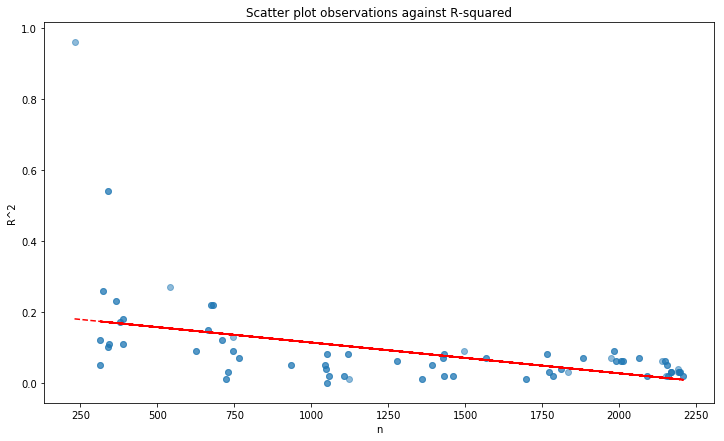

In [17]:
# Define the data to be used for the scatterplot
x = df_infl.loc[:,"n"]
y = df_infl.loc[:,"R^2"]
 
# Create a scatterplot for the observations and the R-squared
plt.figure(figsize=(12,7))
plt.scatter(x, y, alpha=0.5)
plt.title('Scatter plot observations against R-squared')
plt.xlabel('n')
plt.ylabel('R^2')

# Add trendline
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")

plt.show()

Interestingly, it seems that the more observations, the better the forecasts of the IMF become, as the R-squared goes down as the observations go up. Let's get more of a feel of what the values for R-squared are in this dataset.

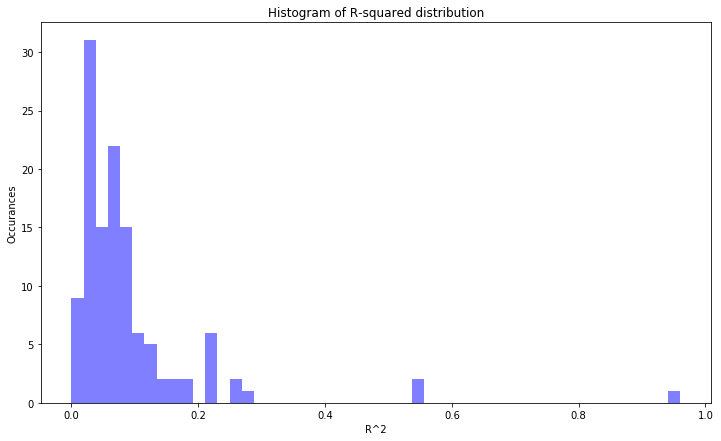

In [18]:
# Specify the number of bins
num_bins = 50
# Specify the data
x = df_infl.loc[:,"R^2"]

# Create the histogram
plt.figure(figsize=(12,7))
n, bins, patches = plt.hist(x, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('R^2')
plt.ylabel('Occurances')
plt.title('Histogram of R-squared distribution')
plt.show()

Much like what the summary statistics seemed to indicate, the majority of the values for R^2 lie below 0.2. Let us zoom in on the p-values to see to what extent these results are statistically significant.

In [19]:
# Create a dataframe with boolean values for whether or not the value is below a significance level of 5%
df_p = df_infl.iloc[:,-5:]<=0.05

print("Amount of p-values that are statistically significant:")
print(df_p[df_p==True].count())
print("\nPercentage of of p-values that are statistically significant:")
print(round(df_p[df_p==True].count()/len(df_p)*100,2))

# Define an extra column that counts how many p-values are significant at a 5% level
df_p["all"]= np.sum(df_p>0,axis=1)

print("\n")
df_count = df_p["all"].value_counts()


l = []
for i in range(0,6):
    a = [i, df_count[i]]
    l.append(a)

df_test = pd.DataFrame(l)
df_test.columns = ["No. of sig. p-values in row", "Occurances"]
print(df_test)

Amount of p-values that are statistically significant:
p-val. t-1    75
p-val. t-2    60
p-val. t-3    64
p-val. t-4    48
p-val. t-5    47
dtype: int64

Percentage of of p-values that are statistically significant:
p-val. t-1    61.98
p-val. t-2    49.59
p-val. t-3    52.89
p-val. t-4    39.67
p-val. t-5    38.84
dtype: float64


   No. of sig. p-values in row  Occurances
0                            0           4
1                            1          25
2                            2          31
3                            3          40
4                            4          18
5                            5           3


We now know that the p-values fluctuate. How do they fluctuate as the R-squared changes? Let us go back to the scatterplot we made earlier, and group the values of R-squared by the amount of significant p-values.

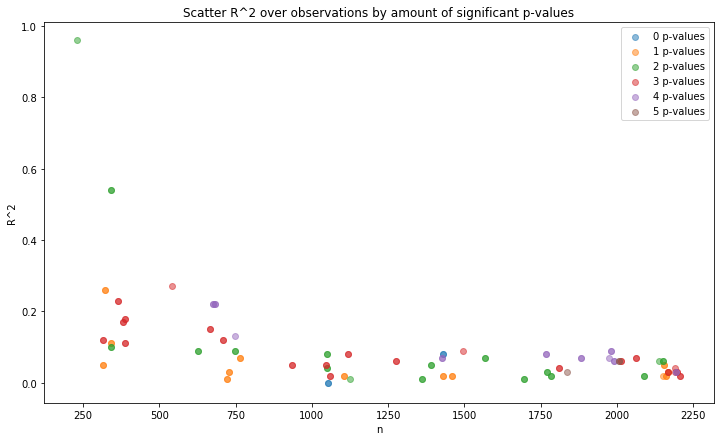

In [170]:
# Add the column that contains the count of significant p-values in each row
df_plot = pd.concat([df_infl, df_p.iloc[:,-1]], axis=1)
df_plot.rename(columns={'all':'sig. p-val. count'}, inplace = True)
df_r2 = df_plot.loc[:,"n":"R^2"]

# Put the values for R^2 and n in two separate lists, grouped by amount of sig. p-vals
l_r2 = []
l_n = []
for i in range(0,6):
    l_r2.append(df_r2.iloc[:,0][df_plot["sig. p-val. count"]==i])
    l_n.append(df_r2.iloc[:,1][df_plot["sig. p-val. count"]==i])

# Create a list of lists with the lists containing the different groups for R^2 and n
l_all = list(zip(l_r2, l_n))

# Specify each of the groups to feed them into the data, and give them names
data = (l_all[0], l_all[1], l_all[2], l_all[3], l_all[4], l_all[5])
groups = ("0 p-values", "1 p-values", "2 p-values", "3 p-values", "4 p-values", "5 p-values")

# Create plot
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(1, 1, 1)
 
for data, color, group in zip(data, colors, groups):
    x, y = data
    ax.scatter(x, y, alpha=0.5, cmap="Set3", label=group)
 
plt.title('Scatter R^2 over observations by amount of significant p-values')
plt.xlabel('n')
plt.ylabel('R^2')
plt.legend(loc=1)
plt.show()

There seems to be no clear relationship between the amount of significant p-values and the number of observations. To get a clearer picture of whether there is a relationship between the value of R^2 and the amount of significant-p-values, it is useful to create some boxplots to see whether the  more statistically significant the results are, the more the independent variables explain the residuals (as shown in R^2). After all, if that is not the case, then our results become less interesting. If the R^2 is increasing with the amount of significant p-values, then we fail to reject this.

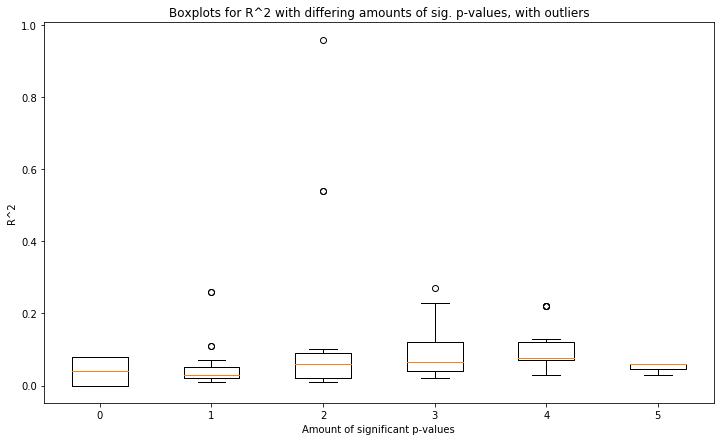

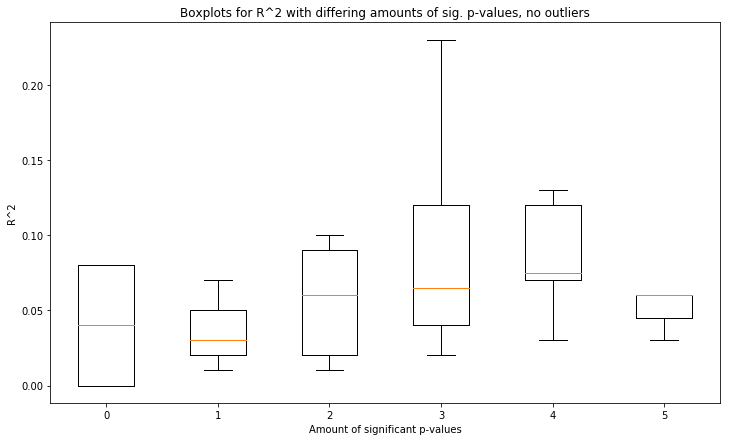

In [168]:
# Add the column that contains the count of significant p-values in each row
df_plot = pd.concat([df_infl, df_p.iloc[:,-1]], axis=1)
df_plot.rename(columns={'all':'sig. p-val. count'}, inplace = True)
df_r2 = df_plot.loc[:,"R^2"]

# Create a dictionary to hold amount of sig. p-vals as key and a list of the values for that specific group as values
d = {}
for i in range(0,6):
    d.update({i:df_r2[df_plot["sig. p-val. count"]==i]})

# Create a list of lists for the data, and a list of keys for the names on the x-axis
data = list(d.values())
groups = list(d.keys())

# Create the first figure with outliers
fig1, ax1 = plt.subplots(figsize=(12,7))
ax1.set_title('Boxplots for R^2 with differing amounts of sig. p-values, with outliers')
ax1.set_ylabel('R^2')
ax1.set_xlabel("Amount of significant p-values")
ax1.boxplot(data, showfliers=True, labels = groups)
plt.show()

# Create the second figure without outliers
fig2, ax2 = plt.subplots(figsize=(12,7))
ax2.set_title('Boxplots for R^2 with differing amounts of sig. p-values, no outliers')
ax2.set_ylabel('R^2')
ax2.set_xlabel("Amount of significant p-values")
ax2.boxplot(data, showfliers=False, labels = groups)
plt.show()

It seems that the R^2 increases as the amount of independent values that are significant increases. This means that we fail to reject that the observed values of R^2 that are higher (read: closer to 0.10) are not significant.

##  <br> <p style="text-align:center;"> ---------- Current Account ---------- </p>

Let's now repeat this exercise for the current account variables:

In [20]:
# Define the list of publications
l_pubs = df_res["Forecast WEO file date"].unique().tolist()
# Select the variable of interest
var_name = "Current Account"
# Get the variable name that belongs to the variable of interest
var = var_dict[var_name]

# Create the dataframe
# Turn the master dataframes into a time series dataframe for the actuals of the variable of interest
df_a = Var_To_TS(df_act, var, "act")
# Turn the master dataframes into a time series dataframe for the residuals of the variable of interest
df_r = Var_To_TS(df_res, var, "res")
# Take the actuals and merge the residuals on to it, this give you a time series dataframe to put in the function
df_reg = pd.merge(df_a, df_r, on=['WEO Country Code', 'ISO', 'Country', 'Forecast WEO file date'])

# Find the regression results for the publications for inflation
df_bca =Results_Table_Builder(l_pubs, var, df_reg)
display(df_bca.head())

,WEO file date,y,x_1,x_2,x_3,x_4,x_5,n,R^2,adj. R^2,coef. t-1,coef. t-2,coef. t-3,coef. t-4,coef. t-5,p-val. t-1,p-val. t-2,p-val. t-3,p-val. t-4,p-val. t-5
0,2007-10-01,BCA res 2007,BCA act 2006,BCA act 2005,BCA act 2004,BCA act 2003,BCA act 2002,293,0.57,0.56,-0.420,1.145,-1.485,0.796,0.173,0.000,0.000,0.000,0.000,0.230
1,2007-10-01,BCA res 2008,BCA act 2006,BCA act 2005,BCA act 2004,BCA act 2003,BCA act 2002,593,0.12,0.11,0.054,-0.240,0.184,1.231,-1.330,0.593,0.183,0.147,0.000,0.000
2,2007-10-01,BCA res 2009,BCA act 2006,BCA act 2005,BCA act 2004,BCA act 2003,BCA act 2002,822,0.50,0.49,0.300,1.083,-2.084,0.789,-0.098,0.008,0.000,0.000,0.001,0.637
3,2007-10-01,BCA res 2010,BCA act 2006,BCA act 2005,BCA act 2004,BCA act 2003,BCA act 2002,1210,0.43,0.43,0.627,0.775,-1.969,-0.815,1.332,0.000,0.000,0.000,0.000,0.000
4,2007-10-01,BCA res 2011,BCA act 2006,BCA act 2005,BCA act 2004,BCA act 2003,BCA act 2002,1551,0.46,0.45,2.069,-1.421,-2.077,0.220,1.407,0.000,0.000,0.000,0.347,0.000


In [50]:
print("Summary statistics for the regressions shown in the table above:")
round(df_bca.describe(),2)

Summary statistics for the regressions shown in the table above:


,n,R^2,adj. R^2,coef. t-1,coef. t-2,coef. t-3,coef. t-4,coef. t-5,p-val. t-1,p-val. t-2,p-val. t-3,p-val. t-4,p-val. t-5
count,121.00,121.00,121.00,121.00,121.00,121.00,121.00,121.00,121.00,121.00,121.00,121.00,121.00
mean,1221.24,0.36,0.35,0.25,0.01,-0.04,-0.17,-0.03,0.09,0.11,0.07,0.06,0.10
std,649.42,0.12,0.12,0.50,0.76,1.20,1.54,1.07,0.18,0.25,0.19,0.18,0.23
min,217.00,0.09,0.07,-0.51,-2.11,-3.48,-4.08,-2.40,0.00,0.00,0.00,0.00,0.00
25%,668.00,0.27,0.27,-0.10,-0.30,-0.52,-0.70,-0.61,0.00,0.00,0.00,0.00,0.00
50%,1145.00,0.39,0.39,0.16,-0.01,-0.03,-0.12,-0.03,0.00,0.00,0.00,0.00,0.00
75%,1739.00,0.44,0.44,0.46,0.52,0.53,0.61,0.46,0.02,0.05,0.00,0.00,0.03
max,2290.00,0.61,0.61,2.07,2.41,3.15,2.97,2.78,0.80,0.98,0.82,0.90,0.89


It looks like the forecasts are more biased when it comes to current account variables, as the mean R-squared is 0.36, while the p-values seem to largely be statistically significant. Let us look at the extent to which the observations play into this.

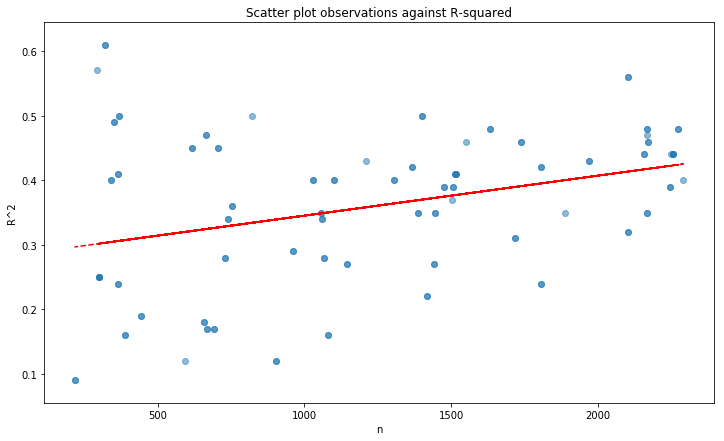

In [17]:
# Define the data to be used for the scatterplot
x = df_bca.loc[:,"n"]
y = df_bca.loc[:,"R^2"]
 
# Create a scatterplot for the observations and the R-squared
plt.figure(figsize=(12,7))
plt.scatter(x, y, alpha=0.5)
plt.title('Scatter plot observations against R-squared')
plt.xlabel('n')
plt.ylabel('R^2')

# Add trendline
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")

plt.show()

The lowest value for n is 217, which is alright. We can expect the results to be better the greater n becomes. It seems that for the larger samples, the spread of the R-squared decreases, particularly the low values for R-squared are absent for high sample sizes. Since the greater the sample, the more reason we have to believe that our results are good, this seems to indicate that the mean R-squared of 0.36 observed in the previous table is not invalid.

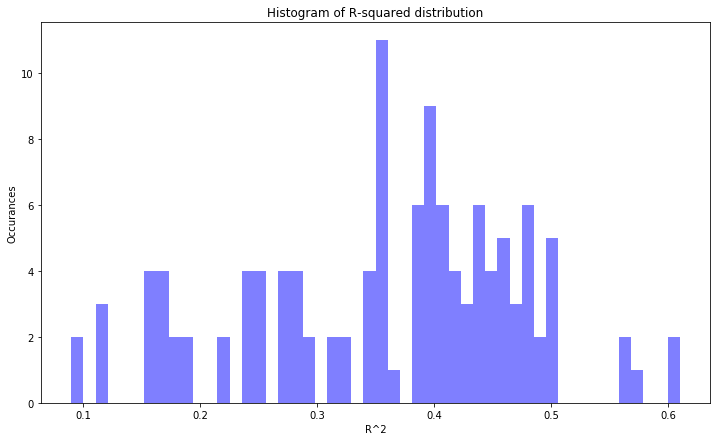

In [19]:
# Specify the number of bins
num_bins = 50
# Specify the data
x = df_bca.loc[:,"R^2"]

# Create the histogram
plt.figure(figsize=(12,7))
n, bins, patches = plt.hist(x, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('R^2')
plt.ylabel('Occurances')
plt.title('Histogram of R-squared distribution')
plt.show()

The spread of the R-squared seems relatively normal around the mean of 0.36. There is a bit more weight on the right hand side of the mean, but the tail is also smaller on that side. This seems to indicate that an average R-squared of 0.36 is not unreasonable.

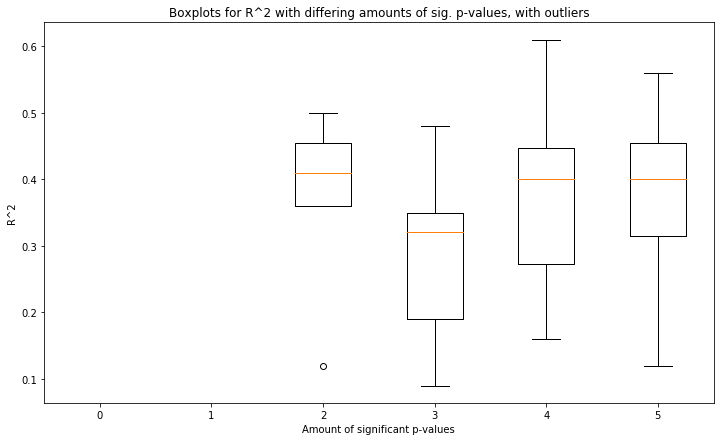

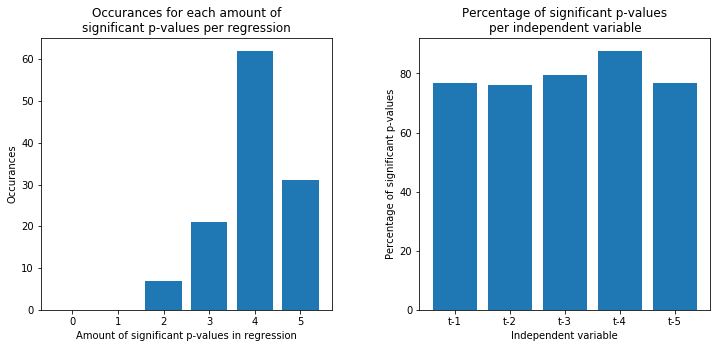


Occurances for each amount of significant p-values per row


,No. of sig. p-values in row,Occurances
0,0,0
1,1,0
2,2,7
3,3,21
4,4,62
5,5,31



Percentage of of p-values that are statistically significant for each independent variable:


,p-vals,pct.
0,t-1,76.859504
1,t-2,76.033058
2,t-3,79.338843
3,t-4,87.603306
4,t-5,76.859504


In [63]:
# Create a dataframe with boolean values for whether or not the value is below a significance level of 5%
df_p = df_bca.iloc[:,-5:]<=0.05
# Define an extra column that counts how many p-values are significant at a 5% level
df_p["all"]= np.sum(df_p>0,axis=1)
# Add the column that contains the count of significant p-values in each row
df_plot = pd.concat([df_bca, df_p.iloc[:,-1]], axis=1)
df_plot.rename(columns={'all':'sig. p-val. count'}, inplace = True)
df_r2 = df_plot.loc[:,"R^2"]
# Create a dictionary to hold amount of sig. p-vals as key and a list of the values for that specific group as values
d = {}
for i in range(0,6):
    d.update({i:df_r2[df_plot["sig. p-val. count"]==i]})

# Manipulate the data of figure 1, create a list of lists for the data, and a list of keys for the names on the x-axis
data = list(d.values())
groups = list(d.keys())

# Create figure 1, a boxplot with outliers
fig1, ax1 = plt.subplots(figsize=(12,7))
ax1.set_title('Boxplots for R^2 with differing amounts of sig. p-values, with outliers')
ax1.set_ylabel('R^2')
ax1.set_xlabel("Amount of significant p-values")
ax1.boxplot(data, showfliers=True, labels = groups)
plt.show()

# Manipulate the data for figure 2
df_count = df_p["all"].value_counts()
l = []
for i in range(0,6):
    try:
        a = [i, df_count[i]]
        l.append(a)
    except:
        a = [i,0]
        l.append(a)
df_test = pd.DataFrame(l)
df_test.columns = ["No. of sig. p-values in row", "Occurances"]

# Initialise the area for figure 2 and 3
plt.figure(figsize=(12,5))

# Define figure 2
# Set the names of the different bars for the bar chart
index = df_test.iloc[:,0]
# Set the height of the bar chart
height = df_test.iloc[:,1]
# Define what place the subplot gets
plt.subplot(1, 2, 1)
# Feed in the data for the bar chart
plt.bar(index, height)
plt.xlabel('Amount of significant p-values in regression')
plt.ylabel('Occurances')
plt.title('Occurances for each amount of\nsignificant p-values per regression')

# Manipulate the data for figure 3, calculate the pct. of each variable (e.g. t-1) that has sig. p-vals
tup_pct_p = df_p[df_p==True].count()/len(df_p)*100
# Stick this data in a dataframe so we can use it for the figure
df_pct_p = pd.DataFrame(tup_pct_p).reset_index()
df_pct_p.columns = ["indep. var.", "pct."]

# Define figure 3
# Set the names of the different bars for the bar chart
l = []
for i in df_pct_p.iloc[:-1,0]:
    i = i[-3:]
    l.append(i)
index = l
# Set the height of the bar chart
height = df_pct_p.iloc[:-1,1]

# Initialise table 2
df_table = pd.DataFrame(height)
df_table.insert(loc=0, column='p-vals', value=l)

# Define what place the subplot gets
plt.subplot(1, 2, 2)
# Feed in the data for the bar chart
plt.bar(index, height)
plt.xlabel('Independent variable')
plt.ylabel('Percentage of significant p-values')
plt.title('Percentage of significant p-values\nper independent variable')
# Create some space between plots
plt.subplots_adjust(wspace = 0.3)

plt.show()

# Print the tables for the figures above tables
print("\nOccurances for each amount of significant p-values per row")
display(df_test)

print("\nPercentage of of p-values that are statistically significant for each independent variable:")
display(df_table)

For the regressions that have more significant p-values (4 or 5), the R-squared appears to be higher, tending towards 0.39. Also, in the table we can see that the majority of the regressions have more than 3 significant p-values. It thus sees that an R-squared of 0.36 is an adequate representation of the regressions of the residual(the IMF forecast - the actual value) on the current account values for the five years years before. This implies that the years before the current account variable explain about 36% of the residual, which seems to indicate there is a clear bias in the IMF forecast.

##  <br> <p style="text-align:center;"> ---------- GDP ---------- </p>

Let's now look at GDP:

In [21]:
# Define the list of publications
l_pubs = df_res["Forecast WEO file date"].unique().tolist()
# Select the variable of interest
var_name = "GDP pct change"
# Get the variable name that belongs to the variable of interest
var = var_dict[var_name]

# Create the dataframe
# Turn the master dataframes into a time series dataframe for the actuals of the variable of interest
df_a = Var_To_TS(df_act, var, "act")
# Turn the master dataframes into a time series dataframe for the residuals of the variable of interest
df_r = Var_To_TS(df_res, var, "res")
# Take the actuals and merge the residuals on to it, this give you a time series dataframe to put in the function
df_reg = pd.merge(df_a, df_r, on=['WEO Country Code', 'ISO', 'Country', 'Forecast WEO file date'])

# Find the regression results for the publications for inflation
df_gdp =Results_Table_Builder(l_pubs, var, df_reg)
display(df_gdp.head())

,WEO file date,y,x_1,x_2,x_3,x_4,x_5,n,R^2,adj. R^2,coef. t-1,coef. t-2,coef. t-3,coef. t-4,coef. t-5,p-val. t-1,p-val. t-2,p-val. t-3,p-val. t-4,p-val. t-5
0,2007-10-01,NGDP_RPCH res 2007,NGDP_RPCH act 2006,NGDP_RPCH act 2005,NGDP_RPCH act 2004,NGDP_RPCH act 2003,NGDP_RPCH act 2002,292,0.01,-0.00,-0.067,0.085,-0.026,0.010,0.023,0.143,0.166,0.359,0.773,0.466
1,2007-10-01,NGDP_RPCH res 2008,NGDP_RPCH act 2006,NGDP_RPCH act 2005,NGDP_RPCH act 2004,NGDP_RPCH act 2003,NGDP_RPCH act 2002,585,0.21,0.20,0.159,0.127,-0.160,-0.009,-0.025,0.000,0.001,0.000,0.684,0.264
2,2007-10-01,NGDP_RPCH res 2009,NGDP_RPCH act 2006,NGDP_RPCH act 2005,NGDP_RPCH act 2004,NGDP_RPCH act 2003,NGDP_RPCH act 2002,808,0.20,0.19,0.296,-0.005,-0.081,0.160,-0.091,0.000,0.932,0.017,0.000,0.010
3,2007-10-01,NGDP_RPCH res 2010,NGDP_RPCH act 2006,NGDP_RPCH act 2005,NGDP_RPCH act 2004,NGDP_RPCH act 2003,NGDP_RPCH act 2002,1198,0.01,0.01,-0.058,0.031,-0.025,0.004,0.008,0.022,0.311,0.242,0.840,0.726
4,2007-10-01,NGDP_RPCH res 2011,NGDP_RPCH act 2006,NGDP_RPCH act 2005,NGDP_RPCH act 2004,NGDP_RPCH act 2003,NGDP_RPCH act 2002,1569,0.03,0.03,-0.039,0.172,-0.114,0.141,-0.103,0.292,0.000,0.000,0.000,0.001


In [52]:
print("Summary statistics for the regressions shown in the table above:")
round(df_gdp.describe(),2)

Summary statistics for the regressions shown in the table above:


,n,R^2,adj. R^2,coef. t-1,coef. t-2,coef. t-3,coef. t-4,coef. t-5,p-val. t-1,p-val. t-2,p-val. t-3,p-val. t-4,p-val. t-5
count,121.00,121.00,121.00,121.00,121.00,121.00,121.00,121.00,121.00,121.00,121.00,121.00,121.00
mean,1233.18,0.09,0.09,0.02,0.02,0.01,0.01,0.01,0.19,0.20,0.26,0.19,0.14
std,652.40,0.07,0.07,0.09,0.10,0.10,0.10,0.08,0.25,0.26,0.33,0.26,0.24
min,238.00,0.01,-0.00,-0.21,-0.37,-0.39,-0.34,-0.29,0.00,0.00,0.00,0.00,0.00
25%,696.00,0.03,0.03,-0.04,-0.04,-0.03,-0.05,-0.04,0.00,0.00,0.00,0.00,0.00
50%,1200.00,0.08,0.08,0.03,0.02,0.01,0.00,0.02,0.04,0.04,0.06,0.06,0.02
75%,1774.00,0.13,0.12,0.07,0.07,0.06,0.06,0.06,0.30,0.30,0.49,0.34,0.14
max,2310.00,0.38,0.37,0.33,0.29,0.24,0.21,0.17,0.99,0.93,0.98,0.94,0.92


It looks like the forecasts are still slightly biased, as the mean R-squared is 0.9, and about half of all the p-values appear to be statistically significant. This is much like what we observed for the inflation variable. Let's look at the extent to which the observations play into this.

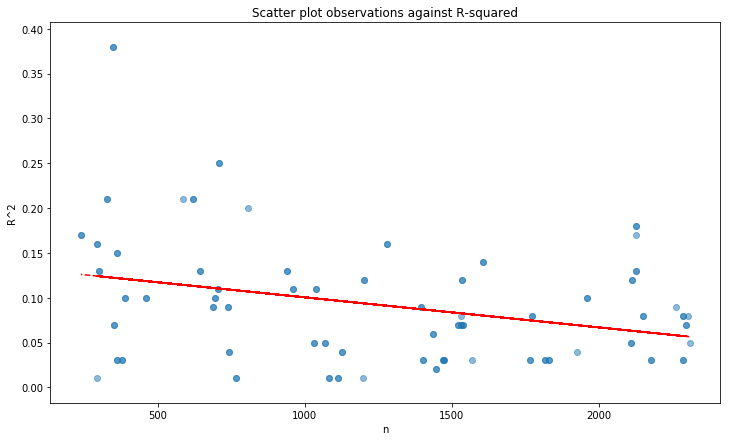

In [54]:
# Define the data to be used for the scatterplot
x = df_gdp.loc[:,"n"]
y = df_gdp.loc[:,"R^2"]
 
# Create a scatterplot for the observations and the R-squared
plt.figure(figsize=(12,7))
plt.scatter(x, y, alpha=0.5)
plt.title('Scatter plot observations against R-squared')
plt.xlabel('n')
plt.ylabel('R^2')

# Add trendline
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")

plt.show()

The lowest value for n is 238, which is alright. We can expect the results to be better the greater n becomes. However, the larger n, the lower R-squared. The strongest positive outliers seem to in the regressions with a low sample size. The larger sample sizes seem to have a mean for R-squared that is around 0.9, just like the mean of the R-squared for the entire dataset. Let's zoom in on the distribution of the R-squared.

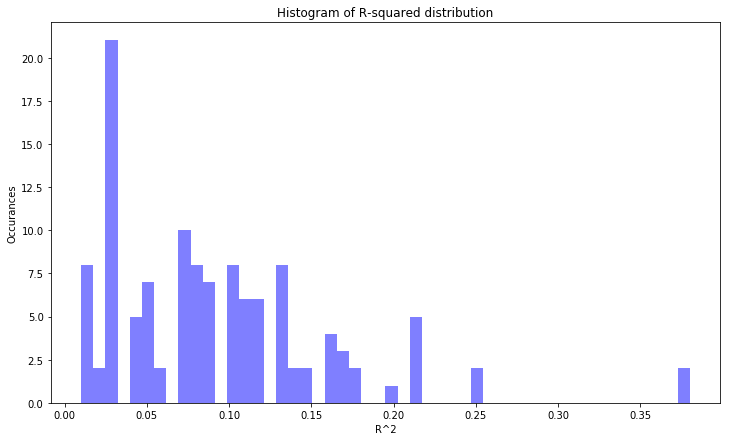

In [47]:
# Specify the number of bins
num_bins = 50
# Specify the data
x = df_gdp.loc[:,"R^2"]

# Create the histogram
plt.figure(figsize=(12,7))
n, bins, patches = plt.hist(x, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('R^2')
plt.ylabel('Occurances')
plt.title('Histogram of R-squared distribution')
plt.show()

The spread of the R-squared appaers to be right skewed, with the bulk of the observations lying in between R-squared 0.00 and 0.20. Let's have a look at the p-values for different values of R-squared:

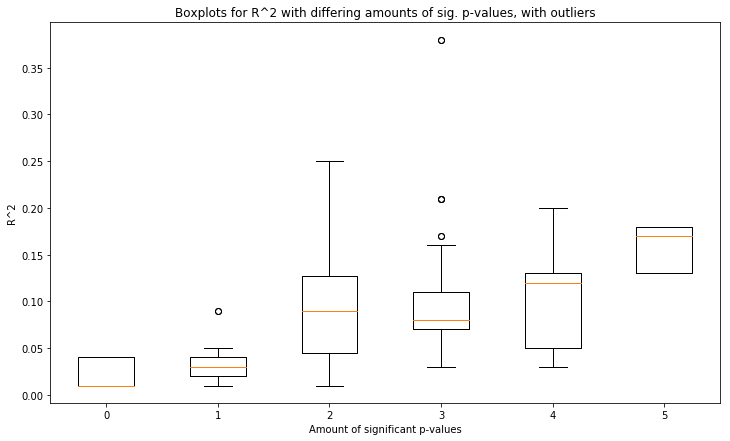

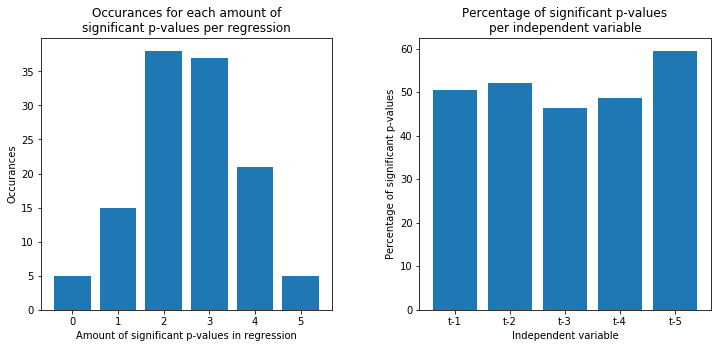


Occurances for each amount of significant p-values per row


,No. of sig. p-values in row,Occurances
0,0,5
1,1,15
2,2,38
3,3,37
4,4,21
5,5,5



Percentage of of p-values that are statistically significant for each independent variable:


,p-vals,pct.
0,t-1,50.413223
1,t-2,52.066116
2,t-3,46.280992
3,t-4,48.760331
4,t-5,59.504132


In [64]:
# Create a dataframe with boolean values for whether or not the value is below a significance level of 5%
df_p = df_gdp.iloc[:,-5:]<=0.05
# Define an extra column that counts how many p-values are significant at a 5% level
df_p["all"]= np.sum(df_p>0,axis=1)
# Add the column that contains the count of significant p-values in each row
df_plot = pd.concat([df_gdp, df_p.iloc[:,-1]], axis=1)
df_plot.rename(columns={'all':'sig. p-val. count'}, inplace = True)
df_r2 = df_plot.loc[:,"R^2"]
# Create a dictionary to hold amount of sig. p-vals as key and a list of the values for that specific group as values
d = {}
for i in range(0,6):
    d.update({i:df_r2[df_plot["sig. p-val. count"]==i]})

# Manipulate the data of figure 1, create a list of lists for the data, and a list of keys for the names on the x-axis
data = list(d.values())
groups = list(d.keys())

# Create figure 1, a boxplot with outliers
fig1, ax1 = plt.subplots(figsize=(12,7))
ax1.set_title('Boxplots for R^2 with differing amounts of sig. p-values, with outliers')
ax1.set_ylabel('R^2')
ax1.set_xlabel("Amount of significant p-values")
ax1.boxplot(data, showfliers=True, labels = groups)
plt.show()

# Manipulate the data for figure 2
df_count = df_p["all"].value_counts()
l = []
for i in range(0,6):
    try:
        a = [i, df_count[i]]
        l.append(a)
    except:
        a = [i,0]
        l.append(a)
df_test = pd.DataFrame(l)
df_test.columns = ["No. of sig. p-values in row", "Occurances"]

# Initialise the area for figure 2 and 3
plt.figure(figsize=(12,5))

# Define figure 2
# Set the names of the different bars for the bar chart
index = df_test.iloc[:,0]
# Set the height of the bar chart
height = df_test.iloc[:,1]
# Define what place the subplot gets
plt.subplot(1, 2, 1)
# Feed in the data for the bar chart
plt.bar(index, height)
plt.xlabel('Amount of significant p-values in regression')
plt.ylabel('Occurances')
plt.title('Occurances for each amount of\nsignificant p-values per regression')

# Manipulate the data for figure 3, calculate the pct. of each variable (e.g. t-1) that has sig. p-vals
tup_pct_p = df_p[df_p==True].count()/len(df_p)*100
# Stick this data in a dataframe so we can use it for the figure
df_pct_p = pd.DataFrame(tup_pct_p).reset_index()
df_pct_p.columns = ["indep. var.", "pct."]

# Define figure 3
# Set the names of the different bars for the bar chart
l = []
for i in df_pct_p.iloc[:-1,0]:
    i = i[-3:]
    l.append(i)
index = l
# Set the height of the bar chart
height = df_pct_p.iloc[:-1,1]

# Initialise table 2
df_table = pd.DataFrame(height)
df_table.insert(loc=0, column='p-vals', value=l)

# Define what place the subplot gets
plt.subplot(1, 2, 2)
# Feed in the data for the bar chart
plt.bar(index, height)
plt.xlabel('Independent variable')
plt.ylabel('Percentage of significant p-values')
plt.title('Percentage of significant p-values\nper independent variable')
# Create some space between plots
plt.subplots_adjust(wspace = 0.3)

plt.show()

# Print the tables for the figures above tables
print("\nOccurances for each amount of significant p-values per row")
display(df_test)

print("\nPercentage of of p-values that are statistically significant for each independent variable:")
display(df_table)

The regressions that have more significant p-values (3, 4, and 5) form a small majority. For these groups, the R-squared appears to be higher, tending towards 0.12. The 20 observations that only have one or less significant p-values (see table number two) seem to put downward pressure on the R-squared, so it is not unrealistic to assume that the R-squared may be slightly upward from the mean of 0.9. The first table shows us that roughly half of the independent variables used in these regressions are statistically significant. Since in about as in about half the regressions, roughly 9-12% of the residuals is explained by the independent variables of the preceding 5 years, which provides some evidence that there may be a systematic bias in the GDP forecasts of the IMF.

##  <br> <p style="text-align:center;"> ---------- Government Debt ---------- </p>

Let's now look at government debt:

In [22]:
# Define the list of publications
l_pubs = df_res["Forecast WEO file date"].unique().tolist()
# Select the variable of interest
var_name = "Net Gov Debt as pct of GDP"
# Get the variable name that belongs to the variable of interest
var = var_dict[var_name]

# Create the dataframe
# Turn the master dataframes into a time series dataframe for the actuals of the variable of interest
df_a = Var_To_TS(df_act, var, "act")
# Turn the master dataframes into a time series dataframe for the residuals of the variable of interest
df_r = Var_To_TS(df_res, var, "res")
# Take the actuals and merge the residuals on to it, this give you a time series dataframe to put in the function
df_reg = pd.merge(df_a, df_r, on=['WEO Country Code', 'ISO', 'Country', 'Forecast WEO file date'])

# Find the regression results for the publications for inflation
df_debt = Results_Table_Builder(l_pubs, var, df_reg)
display(df_debt.head())

,WEO file date,y,x_1,x_2,x_3,x_4,x_5,n,R^2,adj. R^2,coef. t-1,coef. t-2,coef. t-3,coef. t-4,coef. t-5,p-val. t-1,p-val. t-2,p-val. t-3,p-val. t-4,p-val. t-5
0,2007-10-01,GGXWDN_NGDP res 2008,GGXWDN_NGDP act 2006,GGXWDN_NGDP act 2005,GGXWDN_NGDP act 2004,GGXWDN_NGDP act 2003,GGXWDN_NGDP act 2002,4,0.25,-1.25,1.144,310.920,-102.781,-103.549,-100.060,0.781,0.780,0.780,0.780,0.780
1,2007-10-01,GGXWDN_NGDP res 2009,GGXWDN_NGDP act 2006,GGXWDN_NGDP act 2005,GGXWDN_NGDP act 2004,GGXWDN_NGDP act 2003,GGXWDN_NGDP act 2002,32,0.19,0.04,0.358,0.305,-0.404,0.254,-0.602,0.171,0.835,0.814,0.795,0.131
2,2007-10-01,GGXWDN_NGDP res 2010,GGXWDN_NGDP act 2006,GGXWDN_NGDP act 2005,GGXWDN_NGDP act 2004,GGXWDN_NGDP act 2003,GGXWDN_NGDP act 2002,174,0.09,0.06,0.343,0.053,-0.591,0.016,0.272,0.017,0.824,0.081,0.940,0.020
3,2007-10-01,GGXWDN_NGDP res 2011,GGXWDN_NGDP act 2006,GGXWDN_NGDP act 2005,GGXWDN_NGDP act 2004,GGXWDN_NGDP act 2003,GGXWDN_NGDP act 2002,345,0.03,0.02,0.089,0.167,-0.136,-0.078,-0.005,0.455,0.336,0.530,0.648,0.950
4,2007-10-01,GGXWDN_NGDP res 2012,GGXWDN_NGDP act 2006,GGXWDN_NGDP act 2005,GGXWDN_NGDP act 2004,GGXWDN_NGDP act 2003,GGXWDN_NGDP act 2002,506,0.06,0.05,0.155,0.145,-0.052,-0.209,0.019,0.134,0.445,0.840,0.179,0.773


In [54]:
print("Summary statistics for the regressions shown in the table above:")
round(df_debt.describe(),2)

Summary statistics for the regressions shown in the table above:


,n,R^2,adj. R^2,coef. t-1,coef. t-2,coef. t-3,coef. t-4,coef. t-5,p-val. t-1,p-val. t-2,p-val. t-3,p-val. t-4,p-val. t-5
count,120.00,120.00,120.00,120.00,120.00,120.00,120.00,120.00,120.00,120.00,120.00,120.00,120.00
mean,493.17,0.15,0.10,-1.03,3.84,-0.49,-1.21,-0.99,0.19,0.25,0.27,0.22,0.26
std,276.56,0.12,0.25,9.60,29.85,10.05,9.62,9.28,0.26,0.29,0.31,0.29,0.33
min,4.00,0.01,-1.25,-74.32,-3.66,-102.78,-103.55,-100.06,0.00,0.00,0.00,0.00,0.00
25%,237.00,0.06,0.04,-0.16,-0.33,-0.48,-0.60,-0.24,0.00,0.00,0.00,0.00,0.00
50%,507.00,0.12,0.11,0.12,0.13,0.05,-0.08,-0.09,0.02,0.09,0.09,0.08,0.04
75%,692.00,0.23,0.20,0.50,0.47,0.44,0.26,0.08,0.34,0.47,0.50,0.32,0.55
max,924.00,0.57,0.55,1.91,310.92,25.98,3.13,2.63,0.84,0.92,1.00,0.94,0.96


The observations are sometimes rather low, let's look at what this would look like if we set a threshold of n = 100

In [110]:
display(round(df_debt[df_debt.loc[:,"n"]>100].describe(),2))

,n,R^2,adj. R^2,coef. t-1,coef. t-2,coef. t-3,coef. t-4,coef. t-5,p-val. t-1,p-val. t-2,p-val. t-3,p-val. t-4,p-val. t-5
count,112.00,112.00,112.00,112.00,112.00,112.00,112.00,112.00,112.00,112.00,112.00,112.00,112.00
mean,526.93,0.15,0.14,0.20,-0.03,-0.10,-0.08,0.06,0.15,0.23,0.24,0.20,0.22
std,254.43,0.12,0.12,0.59,0.99,1.11,1.07,0.59,0.22,0.28,0.31,0.27,0.30
min,117.00,0.01,0.00,-1.75,-3.66,-3.66,-2.81,-0.73,0.00,0.00,0.00,0.00,0.00
25%,326.00,0.06,0.04,-0.16,-0.38,-0.58,-0.30,-0.24,0.00,0.00,0.00,0.00,0.00
50%,511.00,0.12,0.11,0.12,0.09,0.04,-0.02,-0.09,0.01,0.08,0.08,0.06,0.03
75%,702.00,0.21,0.21,0.51,0.40,0.36,0.28,0.08,0.23,0.45,0.48,0.29,0.44
max,924.00,0.57,0.55,1.91,2.00,2.50,3.13,2.63,0.70,0.92,1.00,0.94,0.95


The R-squared seems to have largely remained the same with a value of 0.15, whereas the p-values become more statistically significant when the outliers are taken out. Interestingly, the greatest value for the sample size is 924, which is less than half of the sample sizes we have seem before. The models must have struggled with a lot of missing observations. Depending on what countries these observations may be from, this may bias the results. If developing countries are systematically left out of the regression, and we assume it is harder to estimate the debt levels for developing countries, then this may lead to an underestimation of the R-squared. Let's have a look at a scatterplot between the R-squared and the amount of observations, to see if any striking relationships stand out:

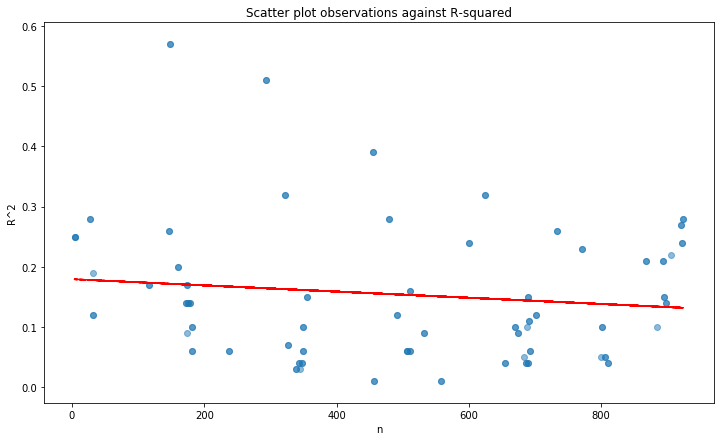

In [97]:
# Define the data to be used for the scatterplot
x = df_debt.loc[:,"n"]
y = df_debt.loc[:,"R^2"]
 
# Create a scatterplot for the observations and the R-squared
plt.figure(figsize=(12,7))
plt.scatter(x, y, alpha=0.5)
plt.title('Scatter plot observations against R-squared')
plt.xlabel('n')
plt.ylabel('R^2')

# Add trendline
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")

plt.show()

Some outliers aside, the spread seems pretty even, although there are less high outliers for greater sample sizes. Other than that, this scatter plot does not seem to indicate any biases we may need to be aware of. Let's zoom in on the distribution of the R-squared:

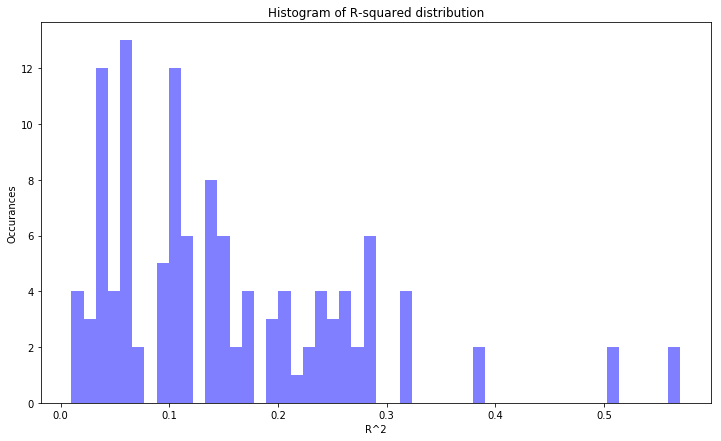

In [98]:
# Specify the number of bins
num_bins = 50
# Specify the data
x = df_debt.loc[:,"R^2"]

# Create the histogram
plt.figure(figsize=(12,7))
n, bins, patches = plt.hist(x, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('R^2')
plt.ylabel('Occurances')
plt.title('Histogram of R-squared distribution')
plt.show()

The spread of the R-squared appears to be right skewed, with the bulk of the observations being centered around 0.1. Let's have a look at the p-values for different values of R-squared:

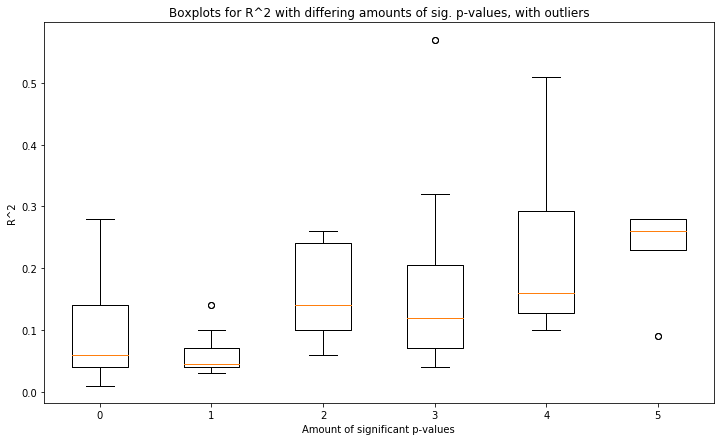

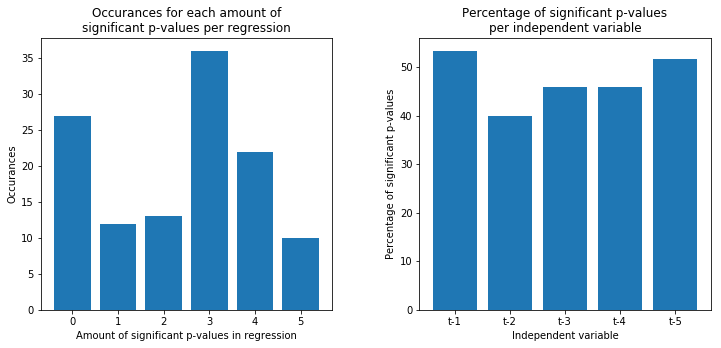


Occurances for each amount of significant p-values per row


,No. of sig. p-values in row,Occurances
0,0,27
1,1,12
2,2,13
3,3,36
4,4,22
5,5,10



Percentage of of p-values that are statistically significant for each independent variable:


,p-vals,pct.
0,t-1,53.333333
1,t-2,40.000000
2,t-3,45.833333
3,t-4,45.833333
4,t-5,51.666667


In [65]:
# Create a dataframe with boolean values for whether or not the value is below a significance level of 5%
df_p = df_debt.iloc[:,-5:]<=0.05
# Define an extra column that counts how many p-values are significant at a 5% level
df_p["all"]= np.sum(df_p>0,axis=1)
# Add the column that contains the count of significant p-values in each row
df_plot = pd.concat([df_debt, df_p.iloc[:,-1]], axis=1)
df_plot.rename(columns={'all':'sig. p-val. count'}, inplace = True)
df_r2 = df_plot.loc[:,"R^2"]
# Create a dictionary to hold amount of sig. p-vals as key and a list of the values for that specific group as values
d = {}
for i in range(0,6):
    d.update({i:df_r2[df_plot["sig. p-val. count"]==i]})

# Manipulate the data of figure 1, create a list of lists for the data, and a list of keys for the names on the x-axis
data = list(d.values())
groups = list(d.keys())

# Create figure 1, a boxplot with outliers
fig1, ax1 = plt.subplots(figsize=(12,7))
ax1.set_title('Boxplots for R^2 with differing amounts of sig. p-values, with outliers')
ax1.set_ylabel('R^2')
ax1.set_xlabel("Amount of significant p-values")
ax1.boxplot(data, showfliers=True, labels = groups)
plt.show()

# Manipulate the data for figure 2
df_count = df_p["all"].value_counts()
l = []
for i in range(0,6):
    try:
        a = [i, df_count[i]]
        l.append(a)
    except:
        a = [i,0]
        l.append(a)
df_test = pd.DataFrame(l)
df_test.columns = ["No. of sig. p-values in row", "Occurances"]

# Initialise the area for figure 2 and 3
plt.figure(figsize=(12,5))

# Define figure 2
# Set the names of the different bars for the bar chart
index = df_test.iloc[:,0]
# Set the height of the bar chart
height = df_test.iloc[:,1]
# Define what place the subplot gets
plt.subplot(1, 2, 1)
# Feed in the data for the bar chart
plt.bar(index, height)
plt.xlabel('Amount of significant p-values in regression')
plt.ylabel('Occurances')
plt.title('Occurances for each amount of\nsignificant p-values per regression')

# Manipulate the data for figure 3, calculate the pct. of each variable (e.g. t-1) that has sig. p-vals
tup_pct_p = df_p[df_p==True].count()/len(df_p)*100
# Stick this data in a dataframe so we can use it for the figure
df_pct_p = pd.DataFrame(tup_pct_p).reset_index()
df_pct_p.columns = ["indep. var.", "pct."]

# Define figure 3
# Set the names of the different bars for the bar chart
l = []
for i in df_pct_p.iloc[:-1,0]:
    i = i[-3:]
    l.append(i)
index = l
# Set the height of the bar chart
height = df_pct_p.iloc[:-1,1]

# Initialise table 2
df_table = pd.DataFrame(height)
df_table.insert(loc=0, column='p-vals', value=l)

# Define what place the subplot gets
plt.subplot(1, 2, 2)
# Feed in the data for the bar chart
plt.bar(index, height)
plt.xlabel('Independent variable')
plt.ylabel('Percentage of significant p-values')
plt.title('Percentage of significant p-values\nper independent variable')
# Create some space between plots
plt.subplots_adjust(wspace = 0.3)

plt.show()

# Print the tables for the figures above tables
print("\nOccurances for each amount of significant p-values per row")
display(df_test)

print("\nPercentage of of p-values that are statistically significant for each independent variable:")
display(df_table)

The regressions that have more significant p-values (3, 4, and 5) form a small majority. For these groups, the R-squared appears to be higher, tending to move beyond 0.15. The first table shows us that roughly half of the independent variables used in these regressions are statistically significant. Since in about half the regressions, roughly 15% of the residuals is explained by the independent variables of the preceding 5 years, which provides some evidence that there may be a systematic bias in the debt forecasts of the IMF.

##  <br> <p style="text-align:center;"> ---------- Output Gap ---------- </p>

Let's look at the regression of the residuals of the output gap on the values for the output gap 5 years prior:

In [23]:
# Define the list of publications
l_pubs = df_res["Forecast WEO file date"].unique().tolist()
# Select the variable of interest
var_name = "Output Gap"
# Get the variable name that belongs to the variable of interest
var = var_dict[var_name]

# Create the dataframe
# Turn the master dataframes into a time series dataframe for the actuals of the variable of interest
df_a = Var_To_TS(df_act, var, "act")
# Turn the master dataframes into a time series dataframe for the residuals of the variable of interest
df_r = Var_To_TS(df_res, var, "res")
# Take the actuals and merge the residuals on to it, this give you a time series dataframe to put in the function
df_reg = pd.merge(df_a, df_r, on=['WEO Country Code', 'ISO', 'Country', 'Forecast WEO file date'])

# Find the regression results for the publications for inflation
df_og = Results_Table_Builder(l_pubs, var, df_reg)
display(df_og.head())

,WEO file date,y,x_1,x_2,x_3,x_4,x_5,n,R^2,adj. R^2,coef. t-1,coef. t-2,coef. t-3,coef. t-4,coef. t-5,p-val. t-1,p-val. t-2,p-val. t-3,p-val. t-4,p-val. t-5
0,2007-10-01,NGAP_NPGDP res 2007,NGAP_NPGDP act 2006,NGAP_NPGDP act 2005,NGAP_NPGDP act 2004,NGAP_NPGDP act 2003,NGAP_NPGDP act 2002,21,0.55,0.41,-1.563,1.569,-1.404,2.297,-2.249,0.271,0.429,0.436,0.036,0.022
1,2007-10-01,NGAP_NPGDP res 2008,NGAP_NPGDP act 2006,NGAP_NPGDP act 2005,NGAP_NPGDP act 2004,NGAP_NPGDP act 2003,NGAP_NPGDP act 2002,57,0.55,0.51,-1.465,2.085,-1.286,1.198,-1.611,0.018,0.011,0.074,0.011,0.000
2,2007-10-01,NGAP_NPGDP res 2009,NGAP_NPGDP act 2006,NGAP_NPGDP act 2005,NGAP_NPGDP act 2004,NGAP_NPGDP act 2003,NGAP_NPGDP act 2002,86,0.16,0.10,0.206,-0.397,0.336,-0.149,-0.661,0.465,0.464,0.510,0.669,0.007
3,2007-10-01,NGAP_NPGDP res 2010,NGAP_NPGDP act 2006,NGAP_NPGDP act 2005,NGAP_NPGDP act 2004,NGAP_NPGDP act 2003,NGAP_NPGDP act 2002,97,0.59,0.57,0.021,0.387,-1.296,2.550,-1.816,0.914,0.309,0.001,0.000,0.000
4,2007-10-01,NGAP_NPGDP res 2011,NGAP_NPGDP act 2006,NGAP_NPGDP act 2005,NGAP_NPGDP act 2004,NGAP_NPGDP act 2003,NGAP_NPGDP act 2002,110,0.60,0.58,0.368,0.505,-1.417,2.626,-2.139,0.026,0.156,0.000,0.000,0.000


In [56]:
print("Summary statistics for the regressions shown in the table above:")
round(df_og.describe(),2)

Summary statistics for the regressions shown in the table above:


,n,R^2,adj. R^2,coef. t-1,coef. t-2,coef. t-3,coef. t-4,coef. t-5,p-val. t-1,p-val. t-2,p-val. t-3,p-val. t-4,p-val. t-5
count,121.00,121.00,121.00,121.00,121.00,121.00,121.00,121.00,121.00,121.00,121.00,121.00,121.00
mean,122.55,0.26,0.23,0.08,-0.04,0.07,0.07,0.06,0.23,0.36,0.39,0.33,0.26
std,42.68,0.15,0.15,0.36,0.47,0.56,0.62,0.52,0.31,0.33,0.34,0.33,0.29
min,21.00,0.04,0.01,-1.56,-0.95,-1.42,-2.32,-2.25,0.00,0.00,0.00,0.00,0.00
25%,99.00,0.14,0.10,-0.02,-0.23,-0.15,-0.15,-0.08,0.00,0.02,0.03,0.03,0.01
50%,130.00,0.23,0.20,0.13,-0.03,0.02,0.03,0.11,0.05,0.26,0.40,0.22,0.14
75%,163.00,0.39,0.32,0.30,0.15,0.30,0.27,0.27,0.35,0.61,0.71,0.64,0.45
max,172.00,0.68,0.65,0.67,2.08,3.11,2.63,1.26,0.97,0.98,0.98,0.95,0.98


The observations are sometimes rather low, let's look at what this would look like if we set a threshold of n = 100

In [17]:
display(round(df_og[df_og.loc[:,"n"]>100].describe(),2))

,n,R^2,adj. R^2,coef. t-1,coef. t-2,coef. t-3,coef. t-4,coef. t-5,p-val. t-1,p-val. t-2,p-val. t-3,p-val. t-4,p-val. t-5
count,89.00,89.00,89.00,89.00,89.00,89.00,89.00,89.00,89.00,89.00,89.00,89.00,89.00
mean,144.03,0.24,0.21,0.14,-0.07,0.02,0.10,0.07,0.20,0.34,0.34,0.32,0.27
std,23.38,0.13,0.13,0.22,0.33,0.35,0.43,0.37,0.29,0.33,0.33,0.32,0.28
min,102.00,0.04,0.01,-0.27,-0.79,-1.42,-0.66,-2.14,0.00,0.00,0.00,0.00,0.00
25%,127.00,0.13,0.10,0.01,-0.21,-0.11,-0.11,-0.08,0.00,0.02,0.02,0.02,0.01
50%,149.00,0.23,0.19,0.14,-0.02,0.02,0.04,0.11,0.03,0.24,0.22,0.25,0.18
75%,165.00,0.32,0.29,0.29,0.11,0.27,0.27,0.22,0.26,0.57,0.63,0.63,0.45
max,172.00,0.60,0.58,0.67,0.61,0.66,2.63,1.05,0.96,0.97,0.98,0.92,0.98


There are 32 regressions that are cut from the table because they had less than 100 observations. The R-squared seems to have lowered a little bit to 0.24, whereas the p-values become more statistically significant when the outliers are taken out. Interestingly, the greatest value for the sample size is 172, which is less relatively little compared to the sample sizes we have seem before. The original data must have a lot of gaps, causing a lot of regressions to not take place. Depending on what countries these observations may be from, this may bias the results. If developing countries are systematically left out of the regression, and we assume it is harder to estimate the output gap for developing countries, then this may lead to an underestimation of the R-squared. Let's have a look at a scatterplot between the R-squared and the amount of observations, to see if any striking relationships stand out:

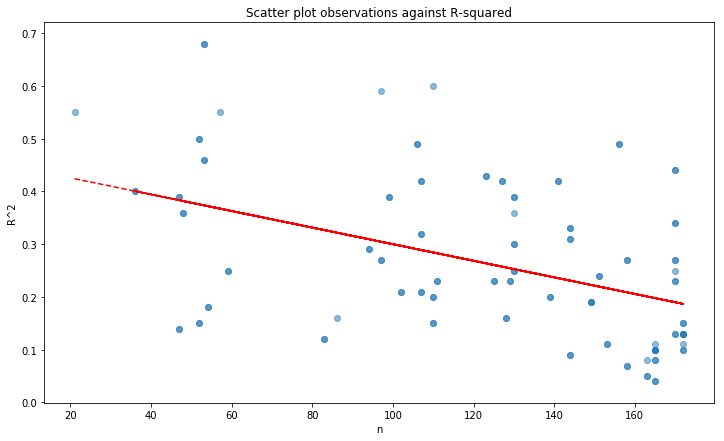

In [18]:
# Define the data to be used for the scatterplot
x = df_og.loc[:,"n"]
y = df_og.loc[:,"R^2"]
 
# Create a scatterplot for the observations and the R-squared
plt.figure(figsize=(12,7))
plt.scatter(x, y, alpha=0.5)
plt.title('Scatter plot observations against R-squared')
plt.xlabel('n')
plt.ylabel('R^2')

# Add trendline
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")

plt.show()

In line with what we saw before, it seems that the more observations are included in the regressions, the lower R-squared becomes on average. Nonetheless, an R-squared of 0.24 is still substantial. Let's zoom in on the distribution of the R-squared:

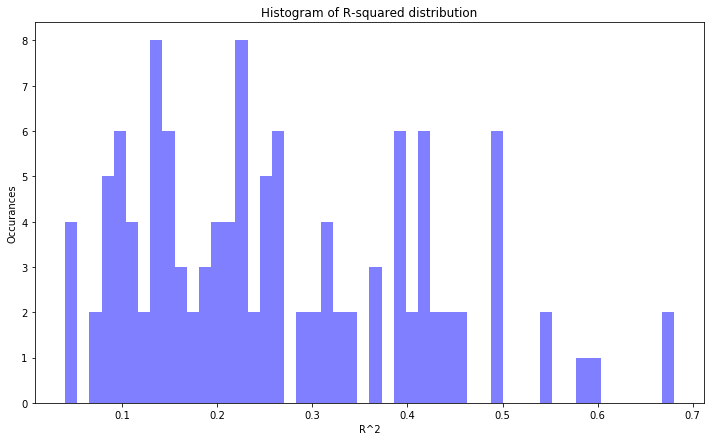

In [19]:
# Specify the number of bins
num_bins = 50
# Specify the data
x = df_og.loc[:,"R^2"]

# Create the histogram
plt.figure(figsize=(12,7))
n, bins, patches = plt.hist(x, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('R^2')
plt.ylabel('Occurances')
plt.title('Histogram of R-squared distribution')
plt.show()

The spread of the R-squared is rather large, and the distribution appears to be right skewed. The bulk of the observations fall between 0 and 0.5. Let's have a look at the p-values for different values of R-squared:

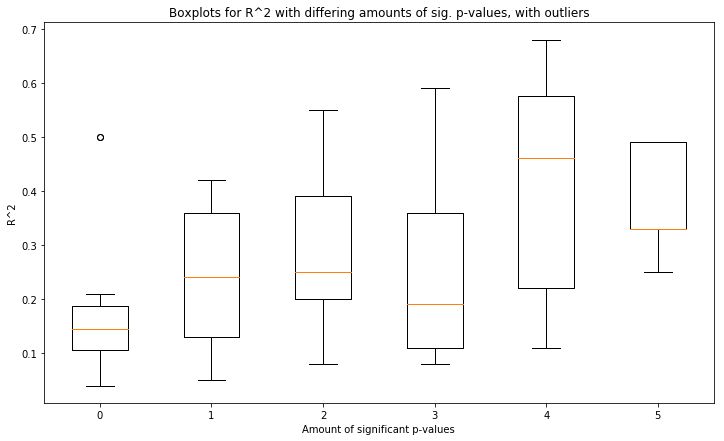

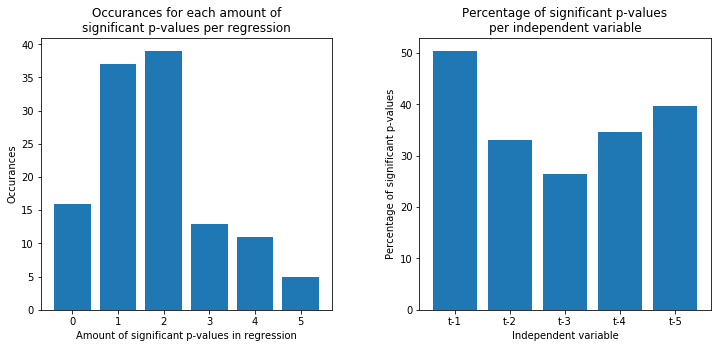


Occurances for each amount of significant p-values per row


,No. of sig. p-values in row,Occurances
0,0,16
1,1,37
2,2,39
3,3,13
4,4,11
5,5,5



Percentage of of p-values that are statistically significant for each independent variable:


,p-vals,pct.
0,t-1,50.413223
1,t-2,33.057851
2,t-3,26.446281
3,t-4,34.710744
4,t-5,39.669421


In [66]:
# Create a dataframe with boolean values for whether or not the value is below a significance level of 5%
df_p = df_og.iloc[:,-5:]<=0.05
# Define an extra column that counts how many p-values are significant at a 5% level
df_p["all"]= np.sum(df_p>0,axis=1)
# Add the column that contains the count of significant p-values in each row
df_plot = pd.concat([df_og, df_p.iloc[:,-1]], axis=1)
df_plot.rename(columns={'all':'sig. p-val. count'}, inplace = True)
df_r2 = df_plot.loc[:,"R^2"]
# Create a dictionary to hold amount of sig. p-vals as key and a list of the values for that specific group as values
d = {}
for i in range(0,6):
    d.update({i:df_r2[df_plot["sig. p-val. count"]==i]})

# Manipulate the data of figure 1, create a list of lists for the data, and a list of keys for the names on the x-axis
data = list(d.values())
groups = list(d.keys())

# Create figure 1, a boxplot with outliers
fig1, ax1 = plt.subplots(figsize=(12,7))
ax1.set_title('Boxplots for R^2 with differing amounts of sig. p-values, with outliers')
ax1.set_ylabel('R^2')
ax1.set_xlabel("Amount of significant p-values")
ax1.boxplot(data, showfliers=True, labels = groups)
plt.show()

# Manipulate the data for figure 2
df_count = df_p["all"].value_counts()
l = []
for i in range(0,6):
    try:
        a = [i, df_count[i]]
        l.append(a)
    except:
        a = [i,0]
        l.append(a)
df_test = pd.DataFrame(l)
df_test.columns = ["No. of sig. p-values in row", "Occurances"]

# Initialise the area for figure 2 and 3
plt.figure(figsize=(12,5))

# Define figure 2
# Set the names of the different bars for the bar chart
index = df_test.iloc[:,0]
# Set the height of the bar chart
height = df_test.iloc[:,1]
# Define what place the subplot gets
plt.subplot(1, 2, 1)
# Feed in the data for the bar chart
plt.bar(index, height)
plt.xlabel('Amount of significant p-values in regression')
plt.ylabel('Occurances')
plt.title('Occurances for each amount of\nsignificant p-values per regression')

# Manipulate the data for figure 3, calculate the pct. of each variable (e.g. t-1) that has sig. p-vals
tup_pct_p = df_p[df_p==True].count()/len(df_p)*100
# Stick this data in a dataframe so we can use it for the figure
df_pct_p = pd.DataFrame(tup_pct_p).reset_index()
df_pct_p.columns = ["indep. var.", "pct."]

# Define figure 3
# Set the names of the different bars for the bar chart
l = []
for i in df_pct_p.iloc[:-1,0]:
    i = i[-3:]
    l.append(i)
index = l
# Set the height of the bar chart
height = df_pct_p.iloc[:-1,1]

# Initialise table 2
df_table = pd.DataFrame(height)
df_table.insert(loc=0, column='p-vals', value=l)

# Define what place the subplot gets
plt.subplot(1, 2, 2)
# Feed in the data for the bar chart
plt.bar(index, height)
plt.xlabel('Independent variable')
plt.ylabel('Percentage of significant p-values')
plt.title('Percentage of significant p-values\nper independent variable')
# Create some space between plots
plt.subplots_adjust(wspace = 0.3)

plt.show()

# Print the tables for the figures above tables
print("\nOccurances for each amount of significant p-values per row")
display(df_test)

print("\nPercentage of of p-values that are statistically significant for each independent variable:")
display(df_table)

The majority of the regressions have only one or two significant p-values, which is not a whole lot. Overall, about 30% of all p-values are statistically significant, which again is not amazing. That being said, over half of the regressions have their first independent variable being significant. Furthermore, the R-squared is high, particularly for those regressions with 4 or 5 significant p-values, with the R-squared tending to move beyond 0.3. Since in about a third the regressions, roughly a quarter of the residuals is explained by the independent variables of the preceding 5 years, which provides some evidence that there may be a systematic bias in the output gap forecasts of the IMF.

##  <br> <p style="text-align:center;"> ---------- Structural Balance ---------- </p>

Let's look at the results for the structural balance:

In [24]:
# Define the list of publications
l_pubs = df_res["Forecast WEO file date"].unique().tolist()
# Select the variable of interest
var_name = "Gov structural balance as pct of pot. GDP"
# Get the variable name that belongs to the variable of interest
var = var_dict[var_name]

# Create the dataframe
# Turn the master dataframes into a time series dataframe for the actuals of the variable of interest
df_a = Var_To_TS(df_act, var, "act")
# Turn the master dataframes into a time series dataframe for the residuals of the variable of interest
df_r = Var_To_TS(df_res, var, "res")
# Take the actuals and merge the residuals on to it, this give you a time series dataframe to put in the function
df_reg = pd.merge(df_a, df_r, on=['WEO Country Code', 'ISO', 'Country', 'Forecast WEO file date'])

# Find the regression results for the publications for inflation
df_sb = Results_Table_Builder(l_pubs, var, df_reg)
display(df_sb.head())

,WEO file date,y,x_1,x_2,x_3,x_4,x_5,n,R^2,adj. R^2,coef. t-1,coef. t-2,coef. t-3,coef. t-4,coef. t-5,p-val. t-1,p-val. t-2,p-val. t-3,p-val. t-4,p-val. t-5
0,2007-10-01,GGSB_NPGDP res 2007,GGSB_NPGDP act 2006,GGSB_NPGDP act 2005,GGSB_NPGDP act 2004,GGSB_NPGDP act 2003,GGSB_NPGDP act 2002,33,0.72,0.66,1.272,-0.265,-1.500,0.879,-0.302,0.000,0.536,0.001,0.053,0.378
1,2007-10-01,GGSB_NPGDP res 2008,GGSB_NPGDP act 2006,GGSB_NPGDP act 2005,GGSB_NPGDP act 2004,GGSB_NPGDP act 2003,GGSB_NPGDP act 2002,69,0.60,0.57,2.390,-0.870,-1.651,0.690,-0.335,0.000,0.188,0.002,0.144,0.410
2,2007-10-01,GGSB_NPGDP res 2009,GGSB_NPGDP act 2006,GGSB_NPGDP act 2005,GGSB_NPGDP act 2004,GGSB_NPGDP act 2003,GGSB_NPGDP act 2002,105,0.50,0.47,2.431,-0.696,-2.117,1.031,-0.550,0.000,0.237,0.000,0.005,0.081
3,2007-10-01,GGSB_NPGDP res 2010,GGSB_NPGDP act 2006,GGSB_NPGDP act 2005,GGSB_NPGDP act 2004,GGSB_NPGDP act 2003,GGSB_NPGDP act 2002,123,0.13,0.09,0.521,-0.300,-0.193,-0.052,0.005,0.016,0.324,0.377,0.704,0.960
4,2007-10-01,GGSB_NPGDP res 2011,GGSB_NPGDP act 2006,GGSB_NPGDP act 2005,GGSB_NPGDP act 2004,GGSB_NPGDP act 2003,GGSB_NPGDP act 2002,177,0.11,0.08,0.311,-0.698,0.373,-0.042,0.049,0.025,0.000,0.013,0.690,0.388


In [58]:
print("Summary statistics for the regressions shown in the table above:")
round(df_sb.describe(),2)

Summary statistics for the regressions shown in the table above:


,n,R^2,adj. R^2,coef. t-1,coef. t-2,coef. t-3,coef. t-4,coef. t-5,p-val. t-1,p-val. t-2,p-val. t-3,p-val. t-4,p-val. t-5
count,121.00,121.00,121.00,121.00,121.00,121.00,121.00,121.00,121.00,121.00,121.00,121.00,121.00
mean,380.97,0.15,0.13,-0.00,0.09,-0.03,-0.04,0.03,0.15,0.18,0.24,0.28,0.26
std,230.50,0.13,0.12,0.39,0.50,0.42,0.44,0.18,0.25,0.27,0.29,0.30,0.28
min,33.00,0.03,0.00,-0.54,-0.87,-2.12,-2.00,-0.55,0.00,0.00,0.00,0.00,0.00
25%,170.00,0.08,0.07,-0.19,-0.19,-0.17,-0.12,-0.08,0.00,0.00,0.00,0.01,0.01
50%,367.00,0.12,0.10,-0.05,0.05,0.00,0.01,0.04,0.01,0.02,0.11,0.15,0.18
75%,610.00,0.18,0.17,0.11,0.22,0.18,0.13,0.11,0.21,0.32,0.43,0.49,0.51
max,805.00,0.72,0.66,2.43,2.51,1.43,1.03,0.62,0.98,0.98,0.95,0.93,0.96


The observations are sometimes rather low, let's look at what this would look like if we set a threshold of n = 100

In [16]:
display(round(df_sb[df_sb.loc[:,"n"]>100].describe(),2))

,n,R^2,adj. R^2,coef. t-1,coef. t-2,coef. t-3,coef. t-4,coef. t-5,p-val. t-1,p-val. t-2,p-val. t-3,p-val. t-4,p-val. t-5
count,111.00,111.00,111.00,111.00,111.00,111.00,111.00,111.00,111.00,111.00,111.00,111.00,111.00
mean,409.92,0.13,0.11,-0.02,0.02,-0.01,0.02,0.02,0.14,0.18,0.24,0.29,0.26
std,218.38,0.07,0.07,0.31,0.28,0.31,0.24,0.15,0.23,0.28,0.30,0.30,0.28
min,104.00,0.03,0.02,-0.54,-0.70,-2.12,-0.60,-0.55,0.00,0.00,0.00,0.00,0.00
25%,210.00,0.07,0.07,-0.19,-0.19,-0.14,-0.10,-0.04,0.00,0.00,0.00,0.03,0.01
50%,389.00,0.12,0.10,-0.05,0.05,0.01,0.01,0.04,0.01,0.02,0.11,0.18,0.17
75%,625.00,0.15,0.14,0.11,0.21,0.14,0.14,0.11,0.19,0.31,0.44,0.49,0.51
max,805.00,0.50,0.47,2.43,0.56,0.48,1.03,0.43,0.98,0.98,0.95,0.93,0.96


The R-squared seems to have come down a little bit to 0.13, while the p-values remain about the same. 

Once more, the amount of regressions that are run is relatively low, with a maximum of 805. Depending on what countries these observations may be from, this may bias the results. If developing countries are systematically left out of the regression, and we assume it is harder to estimate the structural balance levels for developing countries, then this may lead to an underestimation of the R-squared. Let's have a look at a scatterplot between the R-squared and the amount of observations, to see if any striking relationships stand out:

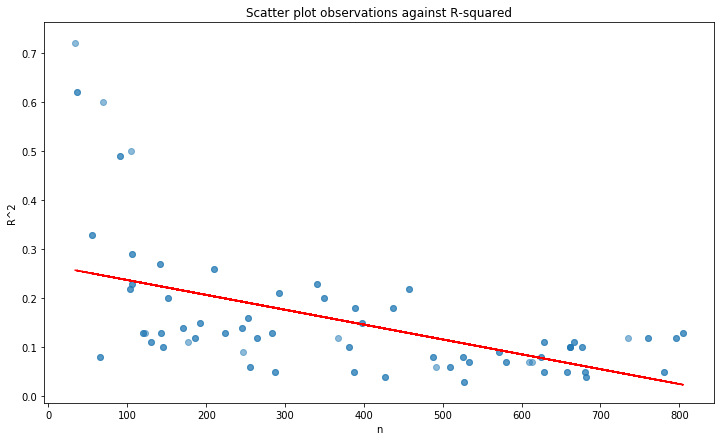

In [17]:
# Define the data to be used for the scatterplot
x = df_sb.loc[:,"n"]
y = df_sb.loc[:,"R^2"]
 
# Create a scatterplot for the observations and the R-squared
plt.figure(figsize=(12,7))
plt.scatter(x, y, alpha=0.5)
plt.title('Scatter plot observations against R-squared')
plt.xlabel('n')
plt.ylabel('R^2')

# Add trendline
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")

plt.show()

This scatterplot shows quite clearly that the mean R-squared is biased downward  by the regressions that have a low amount of observations, as these outliers have high values for R-squared. these outliers aside, it sees that the more observations are included in the regressions, the lower the R-squared becomes. Given that the amount of observations used in the average regression is relatively low, this could make one wonder what the R-squared might have been given a richer sample. Let's zoom in on the distribution of the R-squared:

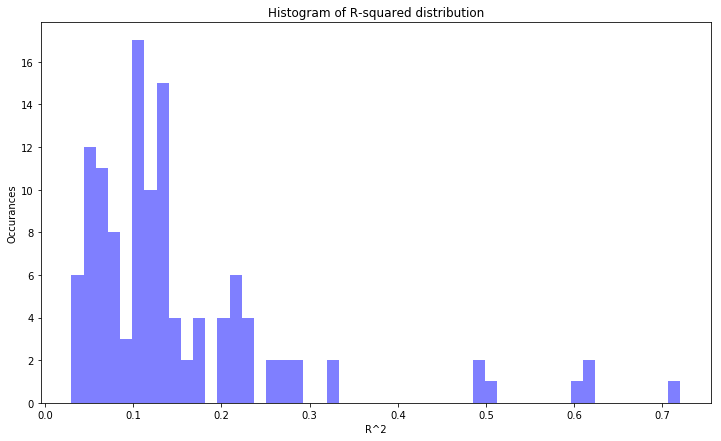

In [18]:
# Specify the number of bins
num_bins = 50
# Specify the data
x = df_sb.loc[:,"R^2"]

# Create the histogram
plt.figure(figsize=(12,7))
n, bins, patches = plt.hist(x, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('R^2')
plt.ylabel('Occurances')
plt.title('Histogram of R-squared distribution')
plt.show()

This histogram also suggests that the outliers put upward pressure on the R-squared, whereas the bulk of the observations lie around 0.1. Let's have a look at the p-values for different values of R-squared:

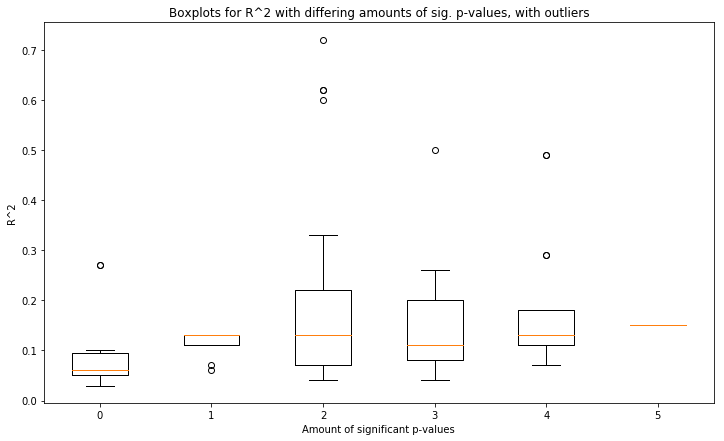

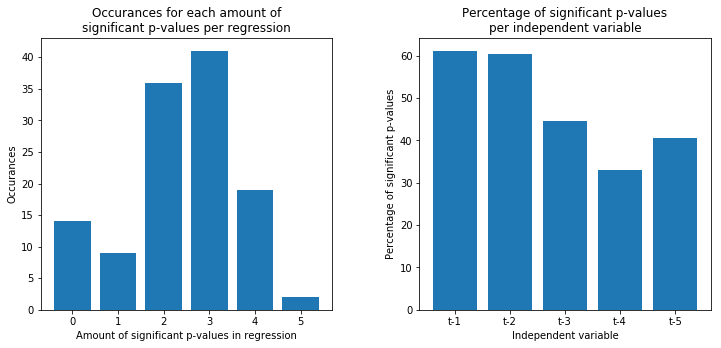


Occurances for each amount of significant p-values per row


,No. of sig. p-values in row,Occurances
0,0,14
1,1,9
2,2,36
3,3,41
4,4,19
5,5,2



Percentage of of p-values that are statistically significant for each independent variable:


,p-vals,pct.
0,t-1,61.157025
1,t-2,60.330579
2,t-3,44.628099
3,t-4,33.057851
4,t-5,40.495868


In [67]:
# Create a dataframe with boolean values for whether or not the value is below a significance level of 5%
df_p = df_sb.iloc[:,-5:]<=0.05
# Define an extra column that counts how many p-values are significant at a 5% level
df_p["all"]= np.sum(df_p>0,axis=1)
# Add the column that contains the count of significant p-values in each row
df_plot = pd.concat([df_sb, df_p.iloc[:,-1]], axis=1)
df_plot.rename(columns={'all':'sig. p-val. count'}, inplace = True)
df_r2 = df_plot.loc[:,"R^2"]
# Create a dictionary to hold amount of sig. p-vals as key and a list of the values for that specific group as values
d = {}
for i in range(0,6):
    d.update({i:df_r2[df_plot["sig. p-val. count"]==i]})

# Manipulate the data of figure 1, create a list of lists for the data, and a list of keys for the names on the x-axis
data = list(d.values())
groups = list(d.keys())

# Create figure 1, a boxplot with outliers
fig1, ax1 = plt.subplots(figsize=(12,7))
ax1.set_title('Boxplots for R^2 with differing amounts of sig. p-values, with outliers')
ax1.set_ylabel('R^2')
ax1.set_xlabel("Amount of significant p-values")
ax1.boxplot(data, showfliers=True, labels = groups)
plt.show()

# Manipulate the data for figure 2
df_count = df_p["all"].value_counts()
l = []
for i in range(0,6):
    try:
        a = [i, df_count[i]]
        l.append(a)
    except:
        a = [i,0]
        l.append(a)
df_test = pd.DataFrame(l)
df_test.columns = ["No. of sig. p-values in row", "Occurances"]

# Initialise the area for figure 2 and 3
plt.figure(figsize=(12,5))

# Define figure 2
# Set the names of the different bars for the bar chart
index = df_test.iloc[:,0]
# Set the height of the bar chart
height = df_test.iloc[:,1]
# Define what place the subplot gets
plt.subplot(1, 2, 1)
# Feed in the data for the bar chart
plt.bar(index, height)
plt.xlabel('Amount of significant p-values in regression')
plt.ylabel('Occurances')
plt.title('Occurances for each amount of\nsignificant p-values per regression')

# Manipulate the data for figure 3, calculate the pct. of each variable (e.g. t-1) that has sig. p-vals
tup_pct_p = df_p[df_p==True].count()/len(df_p)*100
# Stick this data in a dataframe so we can use it for the figure
df_pct_p = pd.DataFrame(tup_pct_p).reset_index()
df_pct_p.columns = ["indep. var.", "pct."]

# Define figure 3
# Set the names of the different bars for the bar chart
l = []
for i in df_pct_p.iloc[:-1,0]:
    i = i[-3:]
    l.append(i)
index = l
# Set the height of the bar chart
height = df_pct_p.iloc[:-1,1]

# Initialise table 2
df_table = pd.DataFrame(height)
df_table.insert(loc=0, column='p-vals', value=l)

# Define what place the subplot gets
plt.subplot(1, 2, 2)
# Feed in the data for the bar chart
plt.bar(index, height)
plt.xlabel('Independent variable')
plt.ylabel('Percentage of significant p-values')
plt.title('Percentage of significant p-values\nper independent variable')
# Create some space between plots
plt.subplots_adjust(wspace = 0.3)

plt.show()

# Print the tables for the figures above tables
print("\nOccurances for each amount of significant p-values per row")
display(df_test)

print("\nPercentage of of p-values that are statistically significant for each independent variable:")
display(df_table)

The bulk of the regressions have lessthan 3 significant p-values. That being said, about 60% have a statistically significant p-value for the first independent variable. The R-squared seems to fluctuate per amount of statistically significant p-values. In almost two-thirds of the regressions, roughly 13% of the residuals is explained by the independent variables of the preceding 5 years, which provides some indication that there may be a systematic bias in the forecasts  of structural balance 
of the IMF.

## <p style="text-align:center;"> ---------- Overview of results ---------- </p>

In [77]:
print("INFLATION\nSummary statistics of the regressions of the residual on the values of the 5 years prior for the inflation variable:")
display(round(df_infl[df_infl.loc[:,"n"]>100].describe(),2))

print("\n" + "*"*106)
print("\nCURRENT ACCOUNT\nSummary statistics of the regressions of the residual on the values of the 5 years prior for the current account variable:")
display(round(df_bca[df_bca.loc[:,"n"]>100].describe(),2))

print("\n" + "*"*106)
print("\nGOVERNMENT DEBT\nSummary statistics of the regressions of the residual on the values of the 5 years prior for the debt variable:")
display(round(df_debt[df_debt.loc[:,"n"]>100].describe(),2))

print("\n" + "*"*106)
print("\nGDP\nSummary statistics of the regressions of the residual on the values of the 5 years prior for the GDP variable:")
display(round(df_gdp[df_gdp.loc[:,"n"]>100].describe(),2))

print("\n" + "*"*106)
print("\nOUTPUT GAP\nSummary statistics of the regressions of the residual on the values of the 5 years prior for the output gap variable:")
display(round(df_og[df_og.loc[:,"n"]>100].describe(),2))

print("\n" + "*"*106)
print("\nSTRUCTURAL BALANCE\nSummary statistics of the regressions of the residual on the values of the 5 years prior for the structural balance variable:")
display(round(df_sb[df_sb.loc[:,"n"]>100].describe(),2))

INFLATION
Summary statistics of the regressions of the residual on the values of the 5 years prior for the inflation variable:


,n,R^2,adj. R^2,coef. t-1,coef. t-2,coef. t-3,coef. t-4,coef. t-5,p-val. t-1,p-val. t-2,p-val. t-3,p-val. t-4,p-val. t-5
count,121.00,121.00,121.00,121.00,121.00,121.00,121.00,121.00,121.00,121.00,121.00,121.00,121.00
mean,1291.60,0.09,0.08,0.14,-0.12,-0.02,-0.02,-0.02,0.13,0.21,0.23,0.31,0.22
std,665.49,0.12,0.12,1.37,1.17,0.12,0.12,0.11,0.24,0.25,0.31,0.34,0.27
min,231.00,0.00,0.00,-1.13,-12.83,-0.43,-0.83,-0.57,0.00,0.00,0.00,0.00,0.00
25%,709.00,0.03,0.03,-0.07,-0.06,-0.07,-0.05,-0.05,0.00,0.00,0.00,0.01,0.01
50%,1361.00,0.06,0.06,0.03,0.01,0.01,-0.00,-0.02,0.00,0.08,0.04,0.14,0.10
75%,1982.00,0.09,0.09,0.08,0.04,0.05,0.04,0.02,0.11,0.42,0.40,0.61,0.30
max,2208.00,0.96,0.96,14.75,0.24,0.28,0.24,0.26,0.96,1.00,0.99,0.98,0.95



**********************************************************************************************************

CURRENT ACCOUNT
Summary statistics of the regressions of the residual on the values of the 5 years prior for the current account variable:


,n,R^2,adj. R^2,coef. t-1,coef. t-2,coef. t-3,coef. t-4,coef. t-5,p-val. t-1,p-val. t-2,p-val. t-3,p-val. t-4,p-val. t-5
count,121.00,121.00,121.00,121.00,121.00,121.00,121.00,121.00,121.00,121.00,121.00,121.00,121.00
mean,1221.24,0.36,0.35,0.25,0.01,-0.04,-0.17,-0.03,0.09,0.11,0.07,0.06,0.10
std,649.42,0.12,0.12,0.50,0.76,1.20,1.54,1.07,0.18,0.25,0.19,0.18,0.23
min,217.00,0.09,0.07,-0.51,-2.11,-3.48,-4.08,-2.40,0.00,0.00,0.00,0.00,0.00
25%,668.00,0.27,0.27,-0.10,-0.30,-0.52,-0.70,-0.61,0.00,0.00,0.00,0.00,0.00
50%,1145.00,0.39,0.39,0.16,-0.01,-0.03,-0.12,-0.03,0.00,0.00,0.00,0.00,0.00
75%,1739.00,0.44,0.44,0.46,0.52,0.53,0.61,0.46,0.02,0.05,0.00,0.00,0.03
max,2290.00,0.61,0.61,2.07,2.41,3.15,2.97,2.78,0.80,0.98,0.82,0.90,0.89



**********************************************************************************************************

GOVERNMENT DEBT
Summary statistics of the regressions of the residual on the values of the 5 years prior for the debt variable:


,n,R^2,adj. R^2,coef. t-1,coef. t-2,coef. t-3,coef. t-4,coef. t-5,p-val. t-1,p-val. t-2,p-val. t-3,p-val. t-4,p-val. t-5
count,112.00,112.00,112.00,112.00,112.00,112.00,112.00,112.00,112.00,112.00,112.00,112.00,112.00
mean,526.93,0.15,0.14,0.20,-0.03,-0.10,-0.08,0.06,0.15,0.23,0.24,0.20,0.22
std,254.43,0.12,0.12,0.59,0.99,1.11,1.07,0.59,0.22,0.28,0.31,0.27,0.30
min,117.00,0.01,0.00,-1.75,-3.66,-3.66,-2.81,-0.73,0.00,0.00,0.00,0.00,0.00
25%,326.00,0.06,0.04,-0.16,-0.38,-0.58,-0.30,-0.24,0.00,0.00,0.00,0.00,0.00
50%,511.00,0.12,0.11,0.12,0.09,0.04,-0.02,-0.09,0.01,0.08,0.08,0.06,0.03
75%,702.00,0.21,0.21,0.51,0.40,0.36,0.28,0.08,0.23,0.45,0.48,0.29,0.44
max,924.00,0.57,0.55,1.91,2.00,2.50,3.13,2.63,0.70,0.92,1.00,0.94,0.95



**********************************************************************************************************

GDP
Summary statistics of the regressions of the residual on the values of the 5 years prior for the GDP variable:


,n,R^2,adj. R^2,coef. t-1,coef. t-2,coef. t-3,coef. t-4,coef. t-5,p-val. t-1,p-val. t-2,p-val. t-3,p-val. t-4,p-val. t-5
count,121.00,121.00,121.00,121.00,121.00,121.00,121.00,121.00,121.00,121.00,121.00,121.00,121.00
mean,1233.18,0.09,0.09,0.02,0.02,0.01,0.01,0.01,0.19,0.20,0.26,0.19,0.14
std,652.40,0.07,0.07,0.09,0.10,0.10,0.10,0.08,0.25,0.26,0.33,0.26,0.24
min,238.00,0.01,-0.00,-0.21,-0.37,-0.39,-0.34,-0.29,0.00,0.00,0.00,0.00,0.00
25%,696.00,0.03,0.03,-0.04,-0.04,-0.03,-0.05,-0.04,0.00,0.00,0.00,0.00,0.00
50%,1200.00,0.08,0.08,0.03,0.02,0.01,0.00,0.02,0.04,0.04,0.06,0.06,0.02
75%,1774.00,0.13,0.12,0.07,0.07,0.06,0.06,0.06,0.30,0.30,0.49,0.34,0.14
max,2310.00,0.38,0.37,0.33,0.29,0.24,0.21,0.17,0.99,0.93,0.98,0.94,0.92



**********************************************************************************************************

OUTPUT GAP
Summary statistics of the regressions of the residual on the values of the 5 years prior for the output gap variable:


,n,R^2,adj. R^2,coef. t-1,coef. t-2,coef. t-3,coef. t-4,coef. t-5,p-val. t-1,p-val. t-2,p-val. t-3,p-val. t-4,p-val. t-5
count,89.00,89.00,89.00,89.00,89.00,89.00,89.00,89.00,89.00,89.00,89.00,89.00,89.00
mean,144.03,0.24,0.21,0.14,-0.07,0.02,0.10,0.07,0.20,0.34,0.34,0.32,0.27
std,23.38,0.13,0.13,0.22,0.33,0.35,0.43,0.37,0.29,0.33,0.33,0.32,0.28
min,102.00,0.04,0.01,-0.27,-0.79,-1.42,-0.66,-2.14,0.00,0.00,0.00,0.00,0.00
25%,127.00,0.13,0.10,0.01,-0.21,-0.11,-0.11,-0.08,0.00,0.02,0.02,0.02,0.01
50%,149.00,0.23,0.19,0.14,-0.02,0.02,0.04,0.11,0.03,0.24,0.22,0.25,0.18
75%,165.00,0.32,0.29,0.29,0.11,0.27,0.27,0.22,0.26,0.57,0.63,0.63,0.45
max,172.00,0.60,0.58,0.67,0.61,0.66,2.63,1.05,0.96,0.97,0.98,0.92,0.98



**********************************************************************************************************

STRUCTURAL BALANCE
Summary statistics of the regressions of the residual on the values of the 5 years prior for the structural balance variable:


,n,R^2,adj. R^2,coef. t-1,coef. t-2,coef. t-3,coef. t-4,coef. t-5,p-val. t-1,p-val. t-2,p-val. t-3,p-val. t-4,p-val. t-5
count,111.00,111.00,111.00,111.00,111.00,111.00,111.00,111.00,111.00,111.00,111.00,111.00,111.00
mean,409.92,0.13,0.11,-0.02,0.02,-0.01,0.02,0.02,0.14,0.18,0.24,0.29,0.26
std,218.38,0.07,0.07,0.31,0.28,0.31,0.24,0.15,0.23,0.28,0.30,0.30,0.28
min,104.00,0.03,0.02,-0.54,-0.70,-2.12,-0.60,-0.55,0.00,0.00,0.00,0.00,0.00
25%,210.00,0.07,0.07,-0.19,-0.19,-0.14,-0.10,-0.04,0.00,0.00,0.00,0.03,0.01
50%,389.00,0.12,0.10,-0.05,0.05,0.01,0.01,0.04,0.01,0.02,0.11,0.18,0.17
75%,625.00,0.15,0.14,0.11,0.21,0.14,0.14,0.11,0.19,0.31,0.44,0.49,0.51
max,805.00,0.50,0.47,2.43,0.56,0.48,1.03,0.43,0.98,0.98,0.95,0.93,0.96


In conclusion, by looking at the p-values and the R-squared, I find that all the six variables analysed in this file (inflation, current account, GDP percentage change, net government debt as percentage of GDP, output gap and the government structural balance as percentage of potential GDP) suffer from a potential bias, with roughly half of all p-values being significant, and average values for R-squared that range from 0.09 to 0.36. Particularly the estimations for the current account variables seem to be suffer from a violation of the zero conditional mean assumption. Given that I have only used the five preceding years as independent variables, I expect that as a more complete set of independent variables were to be used for this analysis, these results would be even stronger. Regardless of whether that is true, however, the analysis performed in this file appears to indicate that there is scope for improvement in the modelling of these forecasts.